In [1]:
import vectorbt as vbt
from vectorbt.portfolio.enums import *

import numpy as np
import pandas as pd
from numba import njit
from datetime import datetime, timedelta

seed = 42

price = pd.Series([1., 2., 3., 4., 5.], index=pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5)
]))
price_wide = price.vbt.tile(3, keys=['a', 'b', 'c'])
print(price.shape, price_wide.shape)

big_price = pd.DataFrame(np.random.uniform(0.9, 1.1, size=(1000,)))
big_price.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_price_wide = big_price.vbt.tile(1000)
print(big_price.shape, big_price_wide.shape)

# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.settings.caching['disable_machinery'] = True
vbt.settings.portfolio['attach_call_seq'] = True

(5,) (5, 3)
(1000, 1) (1000, 1000)


## from_orders

In [2]:
order_size = pd.Series([np.inf, -np.inf, np.nan, np.inf, -np.inf], index=price.index)
order_size_wide = order_size.vbt.tile(3, keys=['a', 'b', 'c'])

big_order_size = pd.DataFrame.vbt.empty((1000,), 1, dtype=np.float_)
big_order_size.iloc[1::2] = -1
big_order_size_wide = big_order_size.vbt.tile(1000)

In [4]:
%timeit vbt.Portfolio.from_orders(big_price, big_order_size, init_cash=np.inf)

2.55 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%timeit vbt.Portfolio.from_orders(big_price_wide, big_order_size_wide, init_cash=np.inf)

102 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%timeit vbt.Portfolio.from_orders(big_price_wide, big_order_size_wide, init_cash=np.inf, jitted=dict(parallel=True))

102 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit vbt.Portfolio.from_orders(big_price_wide, big_order_size_wide, init_cash=np.inf, chunked=True)

120 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit vbt.Portfolio.from_orders(big_price_wide, big_order_size_wide, init_cash=np.inf, chunked='dask')

48.7 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2))

102 ms ± 581 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True)

100 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, call_seq=CallSeqType.Auto)

111 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0))

104 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True)

99.4 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit vbt.Portfolio.from_orders(\
    big_price_wide, big_order_size_wide, init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, call_seq=CallSeqType.Auto)

103 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
def test_per_direction(price=price, size=order_size, **kwargs):
    print('Both')
    try:
        portfolio = vbt.Portfolio.from_orders(price, size, direction='both', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)
    print('LongOnly')
    try:
        portfolio = vbt.Portfolio.from_orders(price, size, direction='longonly', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)
    print('ShortOnly')
    try:
        portfolio = vbt.Portfolio.from_orders(price, size, direction='shortonly', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)

In [16]:
test_per_direction()

Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   0.0     1
2   2    0    3  100.0    4.0   0.0     0
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  100.0    2.0   0.0     1
2   2    0    3   50.0    4.0   0.0     0
3   3    0    4   50.0    5.0   0.0     1
ShortOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     1
1   1    0    1  100.0    2.0   0.0     0


In [17]:
test_per_direction(price=price_wide)

Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   0.0     1
2   2    0    3  100.0    4.0   0.0     0
3   0    1    0  100.0    1.0   0.0     0
4   1    1    1  200.0    2.0   0.0     1
5   2    1    3  100.0    4.0   0.0     0
6   0    2    0  100.0    1.0   0.0     0
7   1    2    1  200.0    2.0   0.0     1
8   2    2    3  100.0    4.0   0.0     0
LongOnly
    id  col  idx   size  price  fees  side
0    0    0    0  100.0    1.0   0.0     0
1    1    0    1  100.0    2.0   0.0     1
2    2    0    3   50.0    4.0   0.0     0
3    3    0    4   50.0    5.0   0.0     1
4    0    1    0  100.0    1.0   0.0     0
5    1    1    1  100.0    2.0   0.0     1
6    2    1    3   50.0    4.0   0.0     0
7    3    1    4   50.0    5.0   0.0     1
8    0    2    0  100.0    1.0   0.0     0
9    1    2    1  100.0    2.0   0.0     1
10   2    2    3   50.0    4.0   0.0     0
11   3    2    4   50.0    5.0   0.0     1
ShortOn

In [18]:
test_per_direction(size=[[np.inf, -np.inf]])

Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   0    1    0  100.0    1.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
ShortOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     1


In [19]:
order_size_one = pd.Series([1, -1, np.nan, 1, -1], index=price.index)

In [20]:
test_per_direction(price=price * 1.01)

Both
   id  col  idx        size  price  fees  side
0   0    0    0   99.009901   1.01   0.0     0
1   1    0    1  198.019802   2.02   0.0     1
2   2    0    3   99.009901   4.04   0.0     0
LongOnly
   id  col  idx       size  price  fees  side
0   0    0    0  99.009901   1.01   0.0     0
1   1    0    1  99.009901   2.02   0.0     1
2   2    0    3  49.504950   4.04   0.0     0
3   3    0    4  49.504950   5.05   0.0     1
ShortOnly
   id  col  idx       size  price  fees  side
0   0    0    0  99.009901   1.01   0.0     1
1   1    0    1  99.009901   2.02   0.0     0


In [21]:
test_per_direction(size=order_size_one, fees=[[0., 0.1, 1.]])

Both
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.0   0.1     0
5    1    1    1   1.0    2.0   0.2     1
6    2    1    3   1.0    4.0   0.4     0
7    3    1    4   1.0    5.0   0.5     1
8    0    2    0   1.0    1.0   1.0     0
9    1    2    1   1.0    2.0   2.0     1
10   2    2    3   1.0    4.0   4.0     0
11   3    2    4   1.0    5.0   5.0     1
LongOnly
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.0   0.1     0
5    1    1    1   1.0    2.0   0.2     1
6    2    1    3   1.0    4.0   0.4     0
7    3    1    4   1.0    5.0   0.5     1
8    0    2    0   1.0    1.0   1.0     0
9    1    2    1   1

In [22]:
test_per_direction(size=order_size_one, fixed_fees=[[0., 0.1, 1.]])

Both
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.0   0.1     0
5    1    1    1   1.0    2.0   0.1     1
6    2    1    3   1.0    4.0   0.1     0
7    3    1    4   1.0    5.0   0.1     1
8    0    2    0   1.0    1.0   1.0     0
9    1    2    1   1.0    2.0   1.0     1
10   2    2    3   1.0    4.0   1.0     0
11   3    2    4   1.0    5.0   1.0     1
LongOnly
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.0   0.1     0
5    1    1    1   1.0    2.0   0.1     1
6    2    1    3   1.0    4.0   0.1     0
7    3    1    4   1.0    5.0   0.1     1
8    0    2    0   1.0    1.0   1.0     0
9    1    2    1   1

In [23]:
test_per_direction(size=order_size_one, slippage=[[0., 0.1, 1.]])

Both
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.1   0.0     0
5    1    1    1   1.0    1.8   0.0     1
6    2    1    3   1.0    4.4   0.0     0
7    3    1    4   1.0    4.5   0.0     1
8    0    2    0   1.0    2.0   0.0     0
9    1    2    1   1.0    0.0   0.0     1
10   2    2    3   1.0    8.0   0.0     0
11   3    2    4   1.0    0.0   0.0     1
LongOnly
    id  col  idx  size  price  fees  side
0    0    0    0   1.0    1.0   0.0     0
1    1    0    1   1.0    2.0   0.0     1
2    2    0    3   1.0    4.0   0.0     0
3    3    0    4   1.0    5.0   0.0     1
4    0    1    0   1.0    1.1   0.0     0
5    1    1    1   1.0    1.8   0.0     1
6    2    1    3   1.0    4.4   0.0     0
7    3    1    4   1.0    4.5   0.0     1
8    0    2    0   1.0    2.0   0.0     0
9    1    2    1   1

In [24]:
test_per_direction(size=order_size_one, min_size=[[0., 1., 2.]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     1
2   2    0    3   1.0    4.0   0.0     0
3   3    0    4   1.0    5.0   0.0     1
4   0    1    0   1.0    1.0   0.0     0
5   1    1    1   1.0    2.0   0.0     1
6   2    1    3   1.0    4.0   0.0     0
7   3    1    4   1.0    5.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     1
2   2    0    3   1.0    4.0   0.0     0
3   3    0    4   1.0    5.0   0.0     1
4   0    1    0   1.0    1.0   0.0     0
5   1    1    1   1.0    2.0   0.0     1
6   2    1    3   1.0    4.0   0.0     0
7   3    1    4   1.0    5.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    1   1.0    2.0   0.0     0
2   2    0    3   1.0    4.0   0.0     1
3   3    0    4   1.0    5.0   0.0     0
4   0    1    0   1.0    1.0   0.

In [25]:
test_per_direction(size=order_size_one, max_size=[[0.5, 1., np.inf]])

Both
    id  col  idx  size  price  fees  side
0    0    0    0   0.5    1.0   0.0     0
1    1    0    1   0.5    2.0   0.0     1
2    2    0    3   0.5    4.0   0.0     0
3    3    0    4   0.5    5.0   0.0     1
4    0    1    0   1.0    1.0   0.0     0
5    1    1    1   1.0    2.0   0.0     1
6    2    1    3   1.0    4.0   0.0     0
7    3    1    4   1.0    5.0   0.0     1
8    0    2    0   1.0    1.0   0.0     0
9    1    2    1   1.0    2.0   0.0     1
10   2    2    3   1.0    4.0   0.0     0
11   3    2    4   1.0    5.0   0.0     1
LongOnly
    id  col  idx  size  price  fees  side
0    0    0    0   0.5    1.0   0.0     0
1    1    0    1   0.5    2.0   0.0     1
2    2    0    3   0.5    4.0   0.0     0
3    3    0    4   0.5    5.0   0.0     1
4    0    1    0   1.0    1.0   0.0     0
5    1    1    1   1.0    2.0   0.0     1
6    2    1    3   1.0    4.0   0.0     0
7    3    1    4   1.0    5.0   0.0     1
8    0    2    0   1.0    1.0   0.0     0
9    1    2    1   1

In [26]:
test_per_direction(size=order_size_one, reject_prob=[[0., 0.5, 1.]], seed=42)

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     1
2   2    0    3   1.0    4.0   0.0     0
3   3    0    4   1.0    5.0   0.0     1
4   0    1    1   1.0    2.0   0.0     1
5   1    1    3   1.0    4.0   0.0     0
6   2    1    4   1.0    5.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     1
2   2    0    3   1.0    4.0   0.0     0
3   3    0    4   1.0    5.0   0.0     1
4   0    1    3   1.0    4.0   0.0     0
5   1    1    4   1.0    5.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    1   1.0    2.0   0.0     0
2   2    0    3   1.0    4.0   0.0     1
3   3    0    4   1.0    5.0   0.0     0
4   0    1    3   1.0    4.0   0.0     1
5   1    1    4   1.0    5.0   0.0     0


In [27]:
test_per_direction(size=pd.Series([np.inf, -np.inf, -np.inf, np.inf, np.inf]), close_first=[[False, True]])

Both
Portfolio.__init__() got an unexpected keyword argument 'close_first'
LongOnly
Portfolio.__init__() got an unexpected keyword argument 'close_first'
ShortOnly
Portfolio.__init__() got an unexpected keyword argument 'close_first'


In [28]:
test_per_direction(size=order_size_one * 1000, allow_partial=[[True, False]])
test_per_direction(size=order_size, allow_partial=[[True, False]])

Both
   id  col  idx    size  price  fees  side
0   0    0    0   100.0    1.0   0.0     0
1   1    0    1  1000.0    2.0   0.0     1
2   2    0    3   500.0    4.0   0.0     0
3   3    0    4  1000.0    5.0   0.0     1
4   0    1    1  1000.0    2.0   0.0     1
5   1    1    4  1000.0    5.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  100.0    2.0   0.0     1
2   2    0    3   50.0    4.0   0.0     0
3   3    0    4   50.0    5.0   0.0     1
ShortOnly
   id  col  idx    size  price  fees  side
0   0    0    0  1000.0    1.0   0.0     1
1   1    0    1   550.0    2.0   0.0     0
2   2    0    3  1000.0    4.0   0.0     1
3   3    0    4   800.0    5.0   0.0     0
4   0    1    0  1000.0    1.0   0.0     1
5   1    1    3  1000.0    4.0   0.0     1
6   2    1    4  1000.0    5.0   0.0     0
Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   

In [29]:
test_per_direction(size=order_size_one * 1000, allow_partial=True, raise_reject=True)
test_per_direction(size=order_size_one * 1000, allow_partial=False, raise_reject=True)

Both
   id  col  idx    size  price  fees  side
0   0    0    0   100.0    1.0   0.0     0
1   1    0    1  1000.0    2.0   0.0     1
2   2    0    3   500.0    4.0   0.0     0
3   3    0    4  1000.0    5.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  100.0    2.0   0.0     1
2   2    0    3   50.0    4.0   0.0     0
3   3    0    4   50.0    5.0   0.0     1
ShortOnly
   id  col  idx    size  price  fees  side
0   0    0    0  1000.0    1.0   0.0     1
1   1    0    1   550.0    2.0   0.0     0
2   2    0    3  1000.0    4.0   0.0     1
3   3    0    4   800.0    5.0   0.0     0
Both
Final size is less than requested
LongOnly
Final size is less than requested
ShortOnly
Final size is less than requested


In [30]:
portfolio = vbt.Portfolio.from_orders(price, order_size, log=True, direction='both')

print(portfolio.logs.records)

   id  group  col  idx  open  high  low  close   cash  position  ...  \
0   0      0    0    0   NaN   NaN  NaN    1.0  100.0       0.0  ...   
1   1      0    0    1   NaN   NaN  NaN    2.0    0.0     100.0  ...   
2   2      0    0    2   NaN   NaN  NaN    3.0  400.0    -100.0  ...   
3   3      0    0    3   NaN   NaN  NaN    4.0  400.0    -100.0  ...   
4   4      0    0    4   NaN   NaN  NaN    5.0    0.0       0.0  ...   

   new_free_cash  new_val_price  new_value  res_size  res_price  res_fees  \
0            0.0            1.0      100.0     100.0        1.0       0.0   
1            0.0            2.0      200.0     200.0        2.0       0.0   
2            0.0            3.0      100.0       NaN        NaN       NaN   
3            0.0            4.0        0.0     100.0        4.0       0.0   
4            0.0            5.0        0.0       NaN        NaN       NaN   

   res_side  res_status  res_status_info  order_id  
0         0           0               -1         0 

In [31]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), direction='both')

print(portfolio.orders.records)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   0.0     1
2   2    0    3  100.0    4.0   0.0     0
3   0    1    0  100.0    1.0   0.0     0
4   1    1    1  200.0    2.0   0.0     1
5   2    1    3  100.0    4.0   0.0     0
6   0    2    0  100.0    1.0   0.0     0
7   1    2    1  200.0    2.0   0.0     1
8   2    2    3  100.0    4.0   0.0     0


In [32]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both')

print(portfolio.orders.records)
print(portfolio.call_seq)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   0.0     1
2   2    0    3  100.0    4.0   0.0     0
3   0    2    0  100.0    1.0   0.0     0
4   1    2    1  200.0    2.0   0.0     1
5   2    2    3  100.0    4.0   0.0     0
            a  b  c
2020-01-01  0  1  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  0  1  0
2020-01-05  0  1  0


In [33]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='reversed')

print(portfolio.orders.records)
print(portfolio.call_seq)

   id  col  idx   size  price  fees  side
0   0    1    0  100.0    1.0   0.0     0
1   1    1    1  200.0    2.0   0.0     1
2   2    1    3  100.0    4.0   0.0     0
3   0    2    0  100.0    1.0   0.0     0
4   1    2    1  200.0    2.0   0.0     1
5   2    2    3  100.0    4.0   0.0     0
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [34]:
portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='random')

print(portfolio.orders.records)
print(portfolio.call_seq)

portfolio = vbt.Portfolio.from_orders(
    price_wide, order_size, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='random', seed=42)

print(portfolio.orders.records)
print(portfolio.call_seq)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    1  200.0    2.0   0.0     1
2   0    1    3  100.0    4.0   0.0     0
3   1    1    4  120.0    5.0   0.0     1
4   0    2    0  100.0    1.0   0.0     0
5   1    2    1  200.0    2.0   0.0     1
6   2    2    3  100.0    4.0   0.0     0
            a  b  c
2020-01-01  0  1  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  1  0  0
2020-01-05  0  1  0
   id  col  idx   size  price  fees  side
0   0    1    0  100.0    1.0   0.0     0
1   1    1    1  200.0    2.0   0.0     1
2   2    1    3  100.0    4.0   0.0     0
3   0    2    0  100.0    1.0   0.0     0
4   1    2    1  200.0    2.0   0.0     1
5   2    2    3  100.0    4.0   0.0     0
            a  b  c
2020-01-01  1  0  0
2020-01-02  0  1  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [41]:
for direction in ('Both', 'LongOnly', 'ShortOnly'):
    print(direction)
    portfolio = vbt.Portfolio.from_orders(1., pd.DataFrame([
        [0., 0., np.inf],
        [0., np.inf, -np.inf],
        [np.inf, -np.inf, 0.],
        [-np.inf, 0., np.inf],
        [0., np.inf, -np.inf],
    ]), group_by=np.array([0, 0, 0]), 
        cash_sharing=True, call_seq='auto', direction=direction)

    print(portfolio.orders.records)
    print(portfolio.call_seq)
    print(portfolio.get_assets())
    print(portfolio.get_value())
    # notice how shorting with np.inf only accounts for current cash, not for other assets!

Both
   id  col  idx   size  price  fees  side
0   0    0    2  200.0    1.0   0.0     0
1   1    0    3  200.0    1.0   0.0     1
2   0    1    1  200.0    1.0   0.0     0
3   1    1    2  200.0    1.0   0.0     1
4   2    1    4  200.0    1.0   0.0     0
5   0    2    0  100.0    1.0   0.0     0
6   1    2    1  200.0    1.0   0.0     1
7   2    2    3  200.0    1.0   0.0     0
8   3    2    4  200.0    1.0   0.0     1
   0  1  2
0  0  1  2
1  2  0  1
2  1  2  0
3  0  1  2
4  2  0  1
       0      1      2
0    0.0    0.0  100.0
1    0.0  200.0 -100.0
2  200.0    0.0 -100.0
3    0.0    0.0  100.0
4    0.0  200.0 -100.0
0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
dtype: float64
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    2  100.0    1.0   0.0     0
1   1    0    3  100.0    1.0   0.0     1
2   0    1    1  100.0    1.0   0.0     0
3   1    1    2  100.0    1.0   0.0     1
4   2    1    4  100.0    1.0   0.0     0
5   0    2    0  100.0    1.0   0.0     

In [42]:
test_per_direction(size=[[75., -75.]], size_type=SizeType.TargetAmount)

portfolio = vbt.Portfolio.from_orders(
    price, [[75., -75.]], size_type=SizeType.TargetAmount, direction='both')
print(portfolio.get_assets())

portfolio = vbt.Portfolio.from_orders(
    price_wide, 75., size_type=SizeType.TargetAmount, 
    group_by=np.array([0, 0, 0]), cash_sharing=True, direction='both')
print(portfolio.orders.records)
print(portfolio.get_assets())

Both
   id  col  idx  size  price  fees  side
0   0    0    0  75.0    1.0   0.0     0
1   0    1    0  75.0    1.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0  75.0    1.0   0.0     0
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0  75.0    1.0   0.0     1
               0     1
2020-01-01  75.0 -75.0
2020-01-02  75.0 -75.0
2020-01-03  75.0 -75.0
2020-01-04  75.0 -75.0
2020-01-05  75.0 -75.0
   id  col  idx  size  price  fees  side
0   0    0    0  75.0    1.0   0.0     0
1   0    1    0  25.0    1.0   0.0     0
               a     b    c
2020-01-01  75.0  25.0  0.0
2020-01-02  75.0  25.0  0.0
2020-01-03  75.0  25.0  0.0
2020-01-04  75.0  25.0  0.0
2020-01-05  75.0  25.0  0.0


In [43]:
test_per_direction(size=[[50., -50.]], size_type=SizeType.TargetValue)

portfolio = vbt.Portfolio.from_orders(
    price, [[50., -50.]], size_type=SizeType.TargetValue, direction='both')
print(portfolio.get_asset_value())

portfolio = vbt.Portfolio.from_orders(
    price_wide, 50., size_type=SizeType.TargetValue, 
    group_by=np.array([0, 0, 0]), cash_sharing=True, direction='both')
print(portfolio.orders.records)
print(portfolio.get_asset_value(group_by=False))

Both
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     0
1   1    0    1  25.000000    2.0   0.0     1
2   2    0    2   8.333333    3.0   0.0     1
3   3    0    3   4.166667    4.0   0.0     1
4   4    0    4   2.500000    5.0   0.0     1
5   0    1    0  50.000000    1.0   0.0     1
6   1    1    1  25.000000    2.0   0.0     0
7   2    1    2   8.333333    3.0   0.0     0
8   3    1    3   4.166667    4.0   0.0     0
9   4    1    4   2.500000    5.0   0.0     0
LongOnly
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     0
1   1    0    1  25.000000    2.0   0.0     1
2   2    0    2   8.333333    3.0   0.0     1
3   3    0    3   4.166667    4.0   0.0     1
4   4    0    4   2.500000    5.0   0.0     1
ShortOnly
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     1
1   1    0    1  25.000000    2.0   0.0     0
2   2    0    2   8.333333    3.0   0.0     0
3   3    0

In [44]:
test_per_direction(size=[[0.5, -0.5]], size_type=SizeType.TargetPercent)

portfolio = vbt.Portfolio.from_orders(
    price, [[0.5, -0.5]], size_type=SizeType.TargetPercent, direction='both')
print(portfolio.get_asset_value() / portfolio.get_value())

portfolio = vbt.Portfolio.from_orders(
    price_wide, 0.5, size_type=SizeType.TargetPercent, 
    group_by=np.array([0, 0, 0]), cash_sharing=True, direction='both')
print(portfolio.orders.records)
print(portfolio.get_asset_value(group_by=False) / portfolio.get_value(group_by=False))

Both
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     0
1   1    0    1  12.500000    2.0   0.0     1
2   2    0    2   6.250000    3.0   0.0     1
3   3    0    3   3.906250    4.0   0.0     1
4   4    0    4   2.734375    5.0   0.0     1
5   0    1    0  50.000000    1.0   0.0     1
6   1    1    1  37.500000    2.0   0.0     0
7   2    1    2   6.250000    3.0   0.0     0
8   3    1    3   2.343750    4.0   0.0     0
9   4    1    4   1.171875    5.0   0.0     0
LongOnly
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     0
1   1    0    1  12.500000    2.0   0.0     1
2   2    0    2   6.250000    3.0   0.0     1
3   3    0    3   3.906250    4.0   0.0     1
4   4    0    4   2.734375    5.0   0.0     1
ShortOnly
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    1.0   0.0     1
1   1    0    1  37.500000    2.0   0.0     0
2   2    0    2   6.250000    3.0   0.0     0
3   3    0

In [45]:
price_one = pd.Series([1., 1., 1., 1., 1.], index=price.index)
target_hold_value = pd.DataFrame({
    'a': [0., 70., 30., 0., 70.],
    'b': [30., 0., 70., 30., 30.],
    'c': [70., 30., 0., 70., 0.]
}, index=price.index)
print(target_hold_value)

               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0


In [46]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value, size_type=SizeType.TargetValue,
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq='random', seed=43)

print(portfolio.orders.records)
print(portfolio.get_asset_flow())
print(portfolio.get_asset_value(group_by=False))  # order fixed -> cannot rebalance properly
print(portfolio.call_seq)

   id  col  idx  size  price  fees  side
0   0    0    4  40.0    1.0   0.0     0
1   0    1    0  30.0    1.0   0.0     0
2   1    1    1  30.0    1.0   0.0     1
3   2    1    2  70.0    1.0   0.0     0
4   3    1    3  40.0    1.0   0.0     1
5   0    2    0  70.0    1.0   0.0     0
6   1    2    1  40.0    1.0   0.0     1
7   2    2    2  30.0    1.0   0.0     1
8   3    2    3  30.0    1.0   0.0     0
9   4    2    4  30.0    1.0   0.0     1
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02   0.0 -30.0 -40.0
2020-01-03   0.0  70.0 -30.0
2020-01-04   0.0 -40.0  30.0
2020-01-05  40.0   0.0 -30.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02   0.0   0.0  30.0
2020-01-03   0.0  70.0   0.0
2020-01-04   0.0  30.0  30.0
2020-01-05  40.0  30.0   0.0
            a  b  c
2020-01-01  1  2  0
2020-01-02  0  2  1
2020-01-03  1  0  2
2020-01-04  0  2  1
2020-01-05  1  0  2


In [47]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value, size_type=SizeType.TargetValue, 
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq='auto')

print(portfolio.orders.records)
print(portfolio.get_asset_flow())
print(portfolio.get_asset_value(group_by=False))  # order dynamic -> can rebalance
print(portfolio.call_seq)

    id  col  idx  size  price  fees  side
0    0    0    1  70.0    1.0   0.0     0
1    1    0    2  40.0    1.0   0.0     1
2    2    0    3  30.0    1.0   0.0     1
3    3    0    4  70.0    1.0   0.0     0
4    0    1    0  30.0    1.0   0.0     0
5    1    1    1  30.0    1.0   0.0     1
6    2    1    2  70.0    1.0   0.0     0
7    3    1    3  40.0    1.0   0.0     1
8    0    2    0  70.0    1.0   0.0     0
9    1    2    1  40.0    1.0   0.0     1
10   2    2    2  30.0    1.0   0.0     1
11   3    2    3  70.0    1.0   0.0     0
12   4    2    4  70.0    1.0   0.0     1
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0 -30.0 -40.0
2020-01-03 -40.0  70.0 -30.0
2020-01-04 -30.0 -40.0  70.0
2020-01-05  70.0   0.0 -70.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0
            a  b  c
2020-01-01  0  1  2
2020-01-02  2  1  0
2020

In [48]:
portfolio = vbt.Portfolio.from_orders(
    price_one, target_hold_value / 100., size_type=SizeType.TargetPercent, 
    group_by=np.array([0, 0, 0]), cash_sharing=True,
    call_seq='auto')

print(portfolio.orders.records)
print(portfolio.get_asset_flow())
print(portfolio.get_asset_value(group_by=False))
print(portfolio.call_seq)

    id  col  idx  size  price  fees  side
0    0    0    1  70.0    1.0   0.0     0
1    1    0    2  40.0    1.0   0.0     1
2    2    0    3  30.0    1.0   0.0     1
3    3    0    4  70.0    1.0   0.0     0
4    0    1    0  30.0    1.0   0.0     0
5    1    1    1  30.0    1.0   0.0     1
6    2    1    2  70.0    1.0   0.0     0
7    3    1    3  40.0    1.0   0.0     1
8    0    2    0  70.0    1.0   0.0     0
9    1    2    1  40.0    1.0   0.0     1
10   2    2    2  30.0    1.0   0.0     1
11   3    2    3  70.0    1.0   0.0     0
12   4    2    4  70.0    1.0   0.0     1
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0 -30.0 -40.0
2020-01-03 -40.0  70.0 -30.0
2020-01-04 -30.0 -40.0  70.0
2020-01-05  70.0   0.0 -70.0
               a     b     c
2020-01-01   0.0  30.0  70.0
2020-01-02  70.0   0.0  30.0
2020-01-03  30.0  70.0   0.0
2020-01-04   0.0  30.0  70.0
2020-01-05  70.0  30.0   0.0
            a  b  c
2020-01-01  0  1  2
2020-01-02  2  1  0
2020

## from_signals

In [49]:
entries = pd.Series([True, True, True, False, False], index=price.index)
entries_wide = entries.vbt.tile(3, keys=['a', 'b', 'c'])
print(entries.shape, entries_wide.shape)

exits = pd.Series([False, False, True, True, True], index=price.index)
exits_wide = exits.vbt.tile(3, keys=['a', 'b', 'c'])
print(exits.shape, exits_wide.shape)

big_entries = pd.DataFrame.vbt.signals.empty((1000,), index=big_price.index)
big_entries.iloc[0::2] = True
big_entries_wide = big_entries.vbt.tile(1000)
print(big_entries.shape, big_entries_wide.shape)

big_exits = pd.DataFrame.vbt.signals.empty((1000,), index=big_price.index)
big_exits.iloc[1::2] = True
big_exits_wide = big_exits.vbt.tile(1000)
print(big_exits.shape, big_exits_wide.shape)

(5,) (5, 3)
(5,) (5, 3)
(1000,) (1000, 1000)
(1000,) (1000, 1000)


In [50]:
%timeit vbt.Portfolio.from_signals(\
    big_price, big_entries, big_exits,\
    size=1., init_cash=np.inf, accumulate=True)

3.34 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True)

112 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True, jitted=dict(parallel=True))

111 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True, chunked=True)

143 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True, chunked='dask')

64.5 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, sl_stop=np.inf, tp_stop=np.inf, accumulate=True)

123 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True, log=True)

356 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2))

116 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True)

113 ms ± 956 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
# worst case
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=np.arange(1000)[::-1], init_cash=np.inf, accumulate=True,\
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, call_seq=CallSeqType.Auto)

122 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0))

114 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=1., init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0), cash_sharing=True)

113 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
# worst case
%timeit vbt.Portfolio.from_signals(\
    big_price_wide, big_entries_wide, big_exits_wide,\
    size=np.arange(1000)[::-1], init_cash=np.inf, accumulate=True,\
    group_by=np.full(1000, 0), cash_sharing=True, call_seq=CallSeqType.Auto)

455 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
def test_per_direction(price=price, entries=entries, exits=exits, **kwargs):
    print('Both')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='both', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)
    print('LongOnly')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='longonly', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)
    print('ShortOnly')
    try:
        portfolio = vbt.Portfolio.from_signals(price, entries, exits, direction='shortonly', **kwargs)
        print(portfolio.orders.records)
    except Exception as e:
        print(e)

In [65]:
test_per_direction()

Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  100.0    4.0   0.0     1
ShortOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     1
1   1    0    3   50.0    4.0   0.0     0


In [66]:
test_per_direction(size=[[0, 1, np.inf]])

Both
   id  col  idx   size  price  fees  side
0   0    1    0    1.0    1.0   0.0     0
1   1    1    3    2.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  200.0    4.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    1    0    1.0    1.0   0.0     0
1   1    1    3    1.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  100.0    4.0   0.0     1
ShortOnly
   id  col  idx   size  price  fees  side
0   0    1    0    1.0    1.0   0.0     1
1   1    1    3    1.0    4.0   0.0     0
2   0    2    0  100.0    1.0   0.0     1
3   1    2    3   50.0    4.0   0.0     0


In [67]:
test_per_direction(size=0.5, size_type='percent')

Both
SizeType.Percent does not support position reversal using signals
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0  50.0    1.0   0.0     0
1   1    0    3  50.0    4.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0  50.0    1.0   0.0     1
1   1    0    3  37.5    4.0   0.0     0


In [68]:
test_per_direction(size=0.5, size_type='percent', accumulate=True)

Both
   id  col  idx    size  price  fees  side
0   0    0    0  50.000    1.0   0.0     0
1   1    0    1  12.500    2.0   0.0     0
2   2    0    3  65.625    4.0   0.0     1
3   3    0    4  26.250    5.0   0.0     1
LongOnly
   id  col  idx    size  price  fees  side
0   0    0    0  50.000    1.0   0.0     0
1   1    0    1  12.500    2.0   0.0     0
2   2    0    3  31.250    4.0   0.0     1
3   3    0    4  15.625    5.0   0.0     1
ShortOnly
   id  col  idx    size  price  fees  side
0   0    0    0  50.000    1.0   0.0     1
1   1    0    1  12.500    2.0   0.0     1
2   2    0    3  21.875    4.0   0.0     0
3   3    0    4   8.750    5.0   0.0     0


In [69]:
test_per_direction(price=price * 1.01)

Both
   id  col  idx        size  price  fees  side
0   0    0    0   99.009901   1.01   0.0     0
1   1    0    3  198.019802   4.04   0.0     1
LongOnly
   id  col  idx       size  price  fees  side
0   0    0    0  99.009901   1.01   0.0     0
1   1    0    3  99.009901   4.04   0.0     1
ShortOnly
   id  col  idx       size  price  fees  side
0   0    0    0  99.009901   1.01   0.0     1
1   1    0    3  49.504950   4.04   0.0     0


In [70]:
test_per_direction(size=1, fees=[[0., 0.1, 1.]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   2.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.1     0
3   1    1    3   2.0    4.0   0.8     1
4   0    2    0   1.0    1.0   1.0     0
5   1    2    3   2.0    4.0   8.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   1.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.1     0
3   1    1    3   1.0    4.0   0.4     1
4   0    2    0   1.0    1.0   1.0     0
5   1    2    3   1.0    4.0   4.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    3   1.0    4.0   0.0     0
2   0    1    0   1.0    1.0   0.1     1
3   1    1    3   1.0    4.0   0.4     0
4   0    2    0   1.0    1.0   1.0     1
5   1    2    3   1.0    4.0   4.0     0


In [71]:
test_per_direction(size=1, fixed_fees=[[0., 0.1, 1.]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   2.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.1     0
3   1    1    3   2.0    4.0   0.1     1
4   0    2    0   1.0    1.0   1.0     0
5   1    2    3   2.0    4.0   1.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   1.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.1     0
3   1    1    3   1.0    4.0   0.1     1
4   0    2    0   1.0    1.0   1.0     0
5   1    2    3   1.0    4.0   1.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    3   1.0    4.0   0.0     0
2   0    1    0   1.0    1.0   0.1     1
3   1    1    3   1.0    4.0   0.1     0
4   0    2    0   1.0    1.0   1.0     1
5   1    2    3   1.0    4.0   1.0     0


In [72]:
test_per_direction(size=1, slippage=[[0., 0.1, 1.]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   2.0    4.0   0.0     1
2   0    1    0   1.0    1.1   0.0     0
3   1    1    3   2.0    3.6   0.0     1
4   0    2    0   1.0    2.0   0.0     0
5   1    2    3   2.0    0.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   1.0    4.0   0.0     1
2   0    1    0   1.0    1.1   0.0     0
3   1    1    3   1.0    3.6   0.0     1
4   0    2    0   1.0    2.0   0.0     0
5   1    2    3   1.0    0.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    3   1.0    4.0   0.0     0
2   0    1    0   1.0    0.9   0.0     1
3   1    1    3   1.0    4.4   0.0     0
4   0    2    0   1.0    0.0   0.0     1
5   1    2    3   1.0    8.0   0.0     0


In [73]:
test_per_direction(size=1, min_size=[[0., 1., 2.]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   2.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.0     0
3   1    1    3   2.0    4.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   1.0    4.0   0.0     1
2   0    1    0   1.0    1.0   0.0     0
3   1    1    3   1.0    4.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    3   1.0    4.0   0.0     0
2   0    1    0   1.0    1.0   0.0     1
3   1    1    3   1.0    4.0   0.0     0


In [74]:
test_per_direction(size=1, max_size=[[0.5, 1., np.inf]])

Both
   id  col  idx  size  price  fees  side
0   0    0    0   0.5    1.0   0.0     0
1   1    0    3   0.5    4.0   0.0     1
2   2    0    4   0.5    5.0   0.0     1
3   0    1    0   1.0    1.0   0.0     0
4   1    1    3   1.0    4.0   0.0     1
5   2    1    4   1.0    5.0   0.0     1
6   0    2    0   1.0    1.0   0.0     0
7   1    2    3   2.0    4.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   0.5    1.0   0.0     0
1   1    0    3   0.5    4.0   0.0     1
2   0    1    0   1.0    1.0   0.0     0
3   1    1    3   1.0    4.0   0.0     1
4   0    2    0   1.0    1.0   0.0     0
5   1    2    3   1.0    4.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   0.5    1.0   0.0     1
1   1    0    3   0.5    4.0   0.0     0
2   0    1    0   1.0    1.0   0.0     1
3   1    1    3   1.0    4.0   0.0     0
4   0    2    0   1.0    1.0   0.0     1
5   1    2    3   1.0    4.0   0.0     0


In [75]:
test_per_direction(size=1., reject_prob=[[0., 0.5, 1.]], seed=42)

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   2.0    4.0   0.0     1
2   0    1    1   1.0    2.0   0.0     0
3   1    1    3   2.0    4.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    3   1.0    4.0   0.0     1
2   0    1    1   1.0    2.0   0.0     0
3   1    1    3   1.0    4.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    3   1.0    4.0   0.0     0
2   0    1    1   1.0    2.0   0.0     1
3   1    1    3   1.0    4.0   0.0     0


In [76]:
portfolio = vbt.Portfolio.from_signals(
    price, entries, exits, direction='both',
    upon_opposite_entry=[['reverse', 'close']]
)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_signals(
    pd.Series(price.values[::-1], index=price.index),
    pd.Series(entries.values[::-1], index=price.index),
    pd.Series(exits.values[::-1], index=price.index), 
    direction='both',
    upon_opposite_entry=[['reverse', 'close']]
)
print(portfolio.orders.records)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
2   0    1    0  100.0    1.0   0.0     0
3   1    1    3  100.0    4.0   0.0     1
4   2    1    4   80.0    5.0   0.0     1
   id  col  idx   size  price  fees  side
0   0    0    0   20.0    5.0   0.0     1
1   1    0    3  100.0    2.0   0.0     0
2   0    1    0   20.0    5.0   0.0     1
3   1    1    3   20.0    2.0   0.0     0
4   2    1    4  160.0    1.0   0.0     0


In [77]:
test_per_direction(size=1000, allow_partial=[[True, False]])
test_per_direction(size=np.inf, allow_partial=[[True, False]])

Both
   id  col  idx    size  price  fees  side
0   0    0    0   100.0    1.0   0.0     0
1   1    0    3  1100.0    4.0   0.0     1
2   0    1    3  1000.0    4.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  100.0    4.0   0.0     1
ShortOnly
   id  col  idx    size  price  fees  side
0   0    0    0  1000.0    1.0   0.0     1
1   1    0    3   275.0    4.0   0.0     0
2   0    1    0  1000.0    1.0   0.0     1
Both
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
2   0    1    0  100.0    1.0   0.0     0
3   1    1    3  200.0    4.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  100.0    4.0   0.0     1
2   0    1    0  100.0    1.0   0.0     0
3   1    1    3  100.0    4.0   0.0     1
ShortOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100

In [78]:
test_per_direction(size=1000, allow_partial=True, raise_reject=True)
test_per_direction(size=1000, allow_partial=False, raise_reject=True)

Both
   id  col  idx    size  price  fees  side
0   0    0    0   100.0    1.0   0.0     0
1   1    0    3  1100.0    4.0   0.0     1
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  100.0    4.0   0.0     1
ShortOnly
Not enough cash to cover fees
Both
Final size is less than requested
LongOnly
Final size is less than requested
ShortOnly
Final size is less than requested


In [79]:
test_per_direction(size=1, accumulate=True)

Both
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     0
2   2    0    3   1.0    4.0   0.0     1
3   3    0    4   1.0    5.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    1   1.0    2.0   0.0     0
2   2    0    3   1.0    4.0   0.0     1
3   3    0    4   1.0    5.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     1
1   1    0    1   1.0    2.0   0.0     1
2   2    0    3   1.0    4.0   0.0     0
3   3    0    4   1.0    5.0   0.0     0


In [80]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, log=True, direction='both')
print(portfolio.orders.records)
print(portfolio.logs.records)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
   id  group  col  idx  open  high  low  close   cash  position  ...  \
0   0      0    0    0   NaN   NaN  NaN    1.0  100.0       0.0  ...   
1   1      0    0    3   NaN   NaN  NaN    4.0    0.0     100.0  ...   

   new_free_cash  new_val_price  new_value  res_size  res_price  res_fees  \
0            0.0            1.0      100.0     100.0        1.0       0.0   
1            0.0            4.0      400.0     200.0        4.0       0.0   

   res_side  res_status  res_status_info  order_id  
0         0           0               -1         0  
1         1           0               -1         1  

[2 rows x 43 columns]


In [81]:
test_per_direction(price=price.iloc[:3], entries=pd.DataFrame([
    [True, True, True, True, True],
    [True, True, True, True, False],
    [True, True, True, True, True]
]), exits=pd.DataFrame([
    [True, True, True, True, True],
    [False, False, False, False, True],
    [True, True, True, True, True]
]), size=1., upon_long_conflict=[[
    'ignore', 
    'entry', 
    'exit', 
    'opposite',
    'opposite'
]], upon_short_conflict=[[
    'ignore', 
    'entry', 
    'exit', 
    'opposite',
    'opposite'
]])

Both
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     0
1   0    1    1   1.0    2.0   0.0     0
2   0    2    1   1.0    2.0   0.0     0
3   0    3    1   1.0    2.0   0.0     0
4   0    4    1   1.0    2.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     0
1   0    1    0   1.0    1.0   0.0     0
2   0    2    1   1.0    2.0   0.0     0
3   1    2    2   1.0    3.0   0.0     1
4   0    3    1   1.0    2.0   0.0     0
5   1    3    2   1.0    3.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     1
1   0    1    0   1.0    1.0   0.0     1
2   0    2    1   1.0    2.0   0.0     1
3   1    2    2   1.0    3.0   0.0     0
4   0    3    1   1.0    2.0   0.0     1
5   1    3    2   1.0    3.0   0.0     0


In [82]:
test_per_direction(price=price.iloc[:3], entries=pd.DataFrame([
    [True, True, True, True, True],
    [True, True, True, True, False],
    [True, True, True, True, True]
]), exits=pd.DataFrame([
    [True, True, True, True, True],
    [False, False, False, False, True],
    [True, True, True, True, True]
]), size=1., upon_dir_conflict=[[
    'ignore', 
    'long', 
    'short', 
    'opposite',
    'opposite'
]])

Both
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     0
1   0    1    0   1.0    1.0   0.0     0
2   0    2    0   1.0    1.0   0.0     1
3   1    2    1   2.0    2.0   0.0     0
4   2    2    2   2.0    3.0   0.0     1
5   0    3    1   1.0    2.0   0.0     0
6   1    3    2   2.0    3.0   0.0     1
7   0    4    1   1.0    2.0   0.0     1
8   1    4    2   2.0    3.0   0.0     0
LongOnly
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     0
1   0    1    1   1.0    2.0   0.0     0
2   0    2    1   1.0    2.0   0.0     0
3   0    3    1   1.0    2.0   0.0     0
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    1   1.0    2.0   0.0     1
1   0    1    1   1.0    2.0   0.0     1
2   0    2    1   1.0    2.0   0.0     1
3   0    3    1   1.0    2.0   0.0     1


In [83]:
test_per_direction(price=price_wide, size=1., init_cash=[0., 1., 100.])
test_per_direction(init_cash=np.inf)

Both
   id  col  idx  size  price  fees  side
0   0    0    3   1.0    4.0   0.0     1
1   0    1    0   1.0    1.0   0.0     0
2   1    1    3   2.0    4.0   0.0     1
3   0    2    0   1.0    1.0   0.0     0
4   1    2    3   2.0    4.0   0.0     1
LongOnly
   id  col  idx  size  price  fees  side
0   0    1    0   1.0    1.0   0.0     0
1   1    1    3   1.0    4.0   0.0     1
2   0    2    0   1.0    1.0   0.0     0
3   1    2    3   1.0    4.0   0.0     1
ShortOnly
   id  col  idx  size  price  fees  side
0   0    0    0  1.00    1.0   0.0     1
1   1    0    3  0.25    4.0   0.0     0
2   0    1    0  1.00    1.0   0.0     1
3   1    1    3  0.50    4.0   0.0     0
4   0    2    0  1.00    1.0   0.0     1
5   1    2    3  1.00    4.0   0.0     0
Both
Attempt to go in long direction infinitely
LongOnly
Attempt to go in long direction infinitely
ShortOnly
Attempt to go in short direction infinitely


In [84]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), direction='both')

print(portfolio.orders.records)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
2   0    1    0  100.0    1.0   0.0     0
3   1    1    3  200.0    4.0   0.0     1
4   0    2    0  100.0    1.0   0.0     0
5   1    2    3  200.0    4.0   0.0     1


In [85]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both')

print(portfolio.orders.records)
print(portfolio.call_seq)
try:
    print(portfolio.regroup(group_by=False))
except Exception as e:
    print(e)

   id  col  idx   size  price  fees  side
0   0    0    0  100.0    1.0   0.0     0
1   1    0    3  200.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  200.0    4.0   0.0     1
            a  b  c
2020-01-01  0  1  0
2020-01-02  0  1  0
2020-01-03  0  1  0
2020-01-04  0  1  0
2020-01-05  0  1  0
Cannot modify grouping globally when cash_sharing=True


In [86]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='reversed')

print(portfolio.orders.records)
print(portfolio.call_seq)

   id  col  idx   size  price  fees  side
0   0    1    0  100.0    1.0   0.0     0
1   1    1    3  200.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  200.0    4.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [87]:
portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='random')

print(portfolio.orders.records)
print(portfolio.call_seq)

portfolio = vbt.Portfolio.from_signals(
    price_wide, entries, exits, 
    group_by=np.array([0, 0, 1]), cash_sharing=True, direction='both', call_seq='random', seed=42)

print(portfolio.orders.records)
print(portfolio.call_seq)

   id  col  idx   size  price  fees  side
0   0    1    0  100.0    1.0   0.0     0
1   1    1    3  200.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  200.0    4.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  0  1  0
   id  col  idx   size  price  fees  side
0   0    1    0  100.0    1.0   0.0     0
1   1    1    3  200.0    4.0   0.0     1
2   0    2    0  100.0    1.0   0.0     0
3   1    2    3  200.0    4.0   0.0     1
            a  b  c
2020-01-01  1  0  0
2020-01-02  0  1  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [88]:
for direction in ('Both', 'LongOnly', 'ShortOnly'):
    print(direction)
    portfolio = vbt.Portfolio.from_signals(1., pd.DataFrame([
        [False, False, True],
        [False, True, False],
        [True, False, False],
        [False, False, True],
        [False, True, False],
    ]), pd.DataFrame([
        [False, False, False],
        [False, False, True],
        [False, True, False],
        [True, False, False],
        [False, False, True],
    ]), group_by=np.array([0, 0, 0]), 
        cash_sharing=True, call_seq='auto', direction=direction)

    print(portfolio.orders.records)
    print(portfolio.call_seq)
    print(portfolio.get_assets())
    print(portfolio.get_value())
    # notice how shorting with np.inf only accounts for current cash, not for other assets!

Both
   id  col  idx   size  price  fees  side
0   0    0    2  200.0    1.0   0.0     0
1   1    0    3  200.0    1.0   0.0     1
2   0    1    1  200.0    1.0   0.0     0
3   1    1    2  200.0    1.0   0.0     1
4   2    1    4  200.0    1.0   0.0     0
5   0    2    0  100.0    1.0   0.0     0
6   1    2    1  200.0    1.0   0.0     1
7   2    2    3  200.0    1.0   0.0     0
8   3    2    4  200.0    1.0   0.0     1
   0  1  2
0  0  1  2
1  2  0  1
2  1  2  0
3  0  1  2
4  2  0  1
       0      1      2
0    0.0    0.0  100.0
1    0.0  200.0 -100.0
2  200.0    0.0 -100.0
3    0.0    0.0  100.0
4    0.0  200.0 -100.0
0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
dtype: float64
LongOnly
   id  col  idx   size  price  fees  side
0   0    0    2  100.0    1.0   0.0     0
1   1    0    3  100.0    1.0   0.0     1
2   0    1    1  100.0    1.0   0.0     0
3   1    1    2  100.0    1.0   0.0     1
4   2    1    4  100.0    1.0   0.0     0
5   0    2    0  100.0    1.0   0.0     

## from_order_func

In [2]:
from vectorbt.portfolio.nb import order_nb, order_nothing_nb

@njit
def order_func_nb(c, size):
    return order_nb(size if c.i % 2 == 0 else -size)

@njit
def flex_order_func_nb(c, size):
    if c.call_idx < c.group_len:
        return c.from_col + c.call_idx, order_nb(size if c.i % 2 == 0 else -size)
    return -1, order_nothing_nb()

In [90]:
%timeit vbt.Portfolio.from_order_func(\
    big_price, order_func_nb, 1., init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price, order_func_nb, 1., init_cash=np.inf, row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price, flex_order_func_nb, 1., init_cash=np.inf, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True)

2.18 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.09 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.14 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True)

155 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
150 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
139 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
136 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, fill_pos_record=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True, fill_pos_record=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True, fill_pos_record=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True, fill_pos_record=False)

119 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
120 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
108 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, track_value=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True, track_value=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True, track_value=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True, track_value=False)

107 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
115 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
100 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
98 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, jitted=dict(parallel=True))
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True, jitted=dict(parallel=True))

153 ms ± 7.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
140 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, chunked=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True, chunked=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True, chunked=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True, chunked=True)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/utils/chunking.py:433: UserWarning: Argument at index 0 not found in SequenceTaker.cont_take_spec. Setting to None.
  return self.take(obj, chunk_meta, **kwargs)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/utils/chunking.py:433: UserWarning: Argument at index 0 not found in SequenceTaker.cont_take_spec. Setting to None.
  return self.take(obj, chunk_meta, **kwargs)


163 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/utils/chunking.py:433: UserWarning: Argument at index 0 not found in SequenceTaker.cont_take_spec. Setting to None.
  return self.take(obj, chunk_meta, **kwargs)


167 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/utils/chunking.py:433: UserWarning: Argument at index 0 not found in SequenceTaker.cont_take_spec. Setting to None.
  return self.take(obj, chunk_meta, **kwargs)


156 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/utils/chunking.py:433: UserWarning: Argument at index 0 not found in SequenceTaker.cont_take_spec. Setting to None.
  return self.take(obj, chunk_meta, **kwargs)


154 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, chunked='dask')
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True, chunked='dask')
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, flexible=True, chunked='dask')
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, flexible=True, chunked='dask')

55.8 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
55 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.8 ms ± 743 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.8 ms ± 429 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, fill_pos_record=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, row_wise=True, fill_pos_record=False)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, fill_pos_record=False, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, row_wise=True, fill_pos_record=False, flexible=True)

118 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
120 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
108 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf, row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), init_cash=np.inf, row_wise=True, flexible=True)

141 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
142 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
137 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf, row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., \
    group_by=np.repeat(np.arange(500), 2), cash_sharing=True, init_cash=np.inf, row_wise=True, flexible=True)

137 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
136 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
129 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0))
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), row_wise=True, flexible=True)

135 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
129 ms ± 96.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [101]:
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, row_wise=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, flexible=True)
%timeit vbt.Portfolio.from_order_func(\
    big_price_wide, flex_order_func_nb, 1., init_cash=np.inf, \
    group_by=np.full(1000, 0), cash_sharing=True, row_wise=True, flexible=True)

125 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
125 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
118 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
119 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
def test_call_seq(call_seq, **kwargs):
    return vbt.Portfolio.from_order_func(
        price_wide, 
        order_func_nb, 
        1.,
        group_by=np.array([0, 0, 0]),
        call_seq=call_seq, **kwargs
    ).call_seq

def big_test_call_seq(call_seq, **kwargs):
    return vbt.Portfolio.from_order_func(
        big_price_wide, 
        order_func_nb, 
        1.,
        group_by=np.repeat(np.arange(500), 2),
        call_seq=call_seq, **kwargs
    ).call_seq

In [103]:
print(test_call_seq(CallSeqType.Default))
%timeit big_test_call_seq(CallSeqType.Default)

print(test_call_seq(CallSeqType.Reversed))
%timeit big_test_call_seq(CallSeqType.Reversed)

print(test_call_seq(CallSeqType.Random))
%timeit big_test_call_seq(CallSeqType.Random)

            a  b  c
2020-01-01  0  1  2
2020-01-02  0  1  2
2020-01-03  0  1  2
2020-01-04  0  1  2
2020-01-05  0  1  2
148 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
155 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
            a  b  c
2020-01-01  1  2  0
2020-01-02  0  1  2
2020-01-03  1  0  2
2020-01-04  1  0  2
2020-01-05  2  1  0
157 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
@njit
def pre_segment_func1_nb(c, *args):
    c.call_seq_now[:] = np.arange(c.to_col - c.from_col - 1, -1, -1)
    return ()

@njit
def pre_segment_func2_nb(c, *args):
    c.call_seq_now[:] = np.copy(c.call_seq_now[::-1])
    return ()

@njit
def pre_segment_func3_nb(c, *args):
    call_seq_now = c.call_seq_now
    n_cols = c.to_col - c.from_col
    for k in range(n_cols):
        call_seq_now[k] = n_cols - k - 1
    return ()

@njit
def pre_segment_func4_nb(c, *args):
    np.random.shuffle(c.call_seq_now)
    return ()

In [105]:
print(test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func1_nb))
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func1_nb)
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func1_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func2_nb))
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func2_nb)
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func2_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func3_nb))
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func3_nb)
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func3_nb, row_wise=True)

print(test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func4_nb))
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func4_nb)  # in-place fastest
%timeit big_test_call_seq(CallSeqType.Default, pre_segment_func_nb=pre_segment_func4_nb, row_wise=True)

            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
290 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
276 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
286 ms ± 951 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
277 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  2  1  0
2020-01-02  2  1  0
2020-01-03  2  1  0
2020-01-04  2  1  0
2020-01-05  2  1  0
159 ms ± 4.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
149 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
            a  b  c
2020-01-01  1  0  2
2020-01-02  1  2  0
2020-01-03  0  2  1
2020-01-04  2  1  0
2020-01-05  0  1  2
217 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
219 ms ± 5.81 ms per loop (mean ± std. dev.

In [4]:
portfolio = vbt.Portfolio.from_order_func(price, order_func_nb, np.inf)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(price, order_func_nb, np.inf, row_wise=True)
print(portfolio.orders.records)

   id  col  idx        size  price  fees  side
0   0    0    0  100.000000    1.0   0.0     0
1   1    0    1  200.000000    2.0   0.0     1
2   2    0    2  133.333333    3.0   0.0     0
3   3    0    3   66.666667    4.0   0.0     1
4   4    0    4   53.333333    5.0   0.0     0
   id  col  idx        size  price  fees  side
0   0    0    0  100.000000    1.0   0.0     0
1   1    0    1  200.000000    2.0   0.0     1
2   2    0    2  133.333333    3.0   0.0     0
3   3    0    3   66.666667    4.0   0.0     1
4   4    0    4   53.333333    5.0   0.0     0


In [5]:
portfolio = vbt.Portfolio.from_order_func(price_wide, order_func_nb, np.inf)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(price_wide, order_func_nb, np.inf, row_wise=True)
print(portfolio.orders.records)

    id  col  idx        size  price  fees  side
0    0    0    0  100.000000    1.0   0.0     0
1    1    0    1  200.000000    2.0   0.0     1
2    2    0    2  133.333333    3.0   0.0     0
3    3    0    3   66.666667    4.0   0.0     1
4    4    0    4   53.333333    5.0   0.0     0
5    0    1    0  100.000000    1.0   0.0     0
6    1    1    1  200.000000    2.0   0.0     1
7    2    1    2  133.333333    3.0   0.0     0
8    3    1    3   66.666667    4.0   0.0     1
9    4    1    4   53.333333    5.0   0.0     0
10   0    2    0  100.000000    1.0   0.0     0
11   1    2    1  200.000000    2.0   0.0     1
12   2    2    2  133.333333    3.0   0.0     0
13   3    2    3   66.666667    4.0   0.0     1
14   4    2    4   53.333333    5.0   0.0     0
    id  col  idx        size  price  fees  side
0    0    0    0  100.000000    1.0   0.0     0
1    1    0    1  200.000000    2.0   0.0     1
2    2    0    2  133.333333    3.0   0.0     0
3    3    0    3   66.666667    4.0   0.

In [6]:
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]))
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), row_wise=True)
print(portfolio.orders.records)

    id  col  idx        size  price  fees  side
0    0    0    0  100.000000    1.0   0.0     0
1    1    0    1  200.000000    2.0   0.0     1
2    2    0    2  133.333333    3.0   0.0     0
3    3    0    3   66.666667    4.0   0.0     1
4    4    0    4   53.333333    5.0   0.0     0
5    0    1    0  100.000000    1.0   0.0     0
6    1    1    1  200.000000    2.0   0.0     1
7    2    1    2  133.333333    3.0   0.0     0
8    3    1    3   66.666667    4.0   0.0     1
9    4    1    4   53.333333    5.0   0.0     0
10   0    2    0  100.000000    1.0   0.0     0
11   1    2    1  200.000000    2.0   0.0     1
12   2    2    2  133.333333    3.0   0.0     0
13   3    2    3   66.666667    4.0   0.0     1
14   4    2    4   53.333333    5.0   0.0     0
    id  col  idx        size  price  fees  side
0    0    0    0  100.000000    1.0   0.0     0
1    1    0    1  200.000000    2.0   0.0     1
2    2    0    2  133.333333    3.0   0.0     0
3    3    0    3   66.666667    4.0   0.

In [7]:
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), cash_sharing=True)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, np.inf,
    group_by=np.array([0, 0, 1]), cash_sharing=True, row_wise=True)
print(portfolio.orders.records)

   id  col  idx        size  price  fees  side
0   0    0    0  100.000000    1.0   0.0     0
1   1    0    1  200.000000    2.0   0.0     1
2   2    0    2  133.333333    3.0   0.0     0
3   3    0    3   66.666667    4.0   0.0     1
4   4    0    4   53.333333    5.0   0.0     0
5   0    2    0  100.000000    1.0   0.0     0
6   1    2    1  200.000000    2.0   0.0     1
7   2    2    2  133.333333    3.0   0.0     0
8   3    2    3   66.666667    4.0   0.0     1
9   4    2    4   53.333333    5.0   0.0     0
   id  col  idx        size  price  fees  side
0   0    0    0  100.000000    1.0   0.0     0
1   1    0    1  200.000000    2.0   0.0     1
2   2    0    2  133.333333    3.0   0.0     0
3   3    0    3   66.666667    4.0   0.0     1
4   4    0    4   53.333333    5.0   0.0     0
5   0    2    0  100.000000    1.0   0.0     0
6   1    2    1  200.000000    2.0   0.0     1
7   2    2    2  133.333333    3.0   0.0     0
8   3    2    3   66.666667    4.0   0.0     1
9   4    2   

In [8]:
@njit
def target_val_pre_segment_func_nb(c, val_price):
    c.last_val_price[c.from_col:c.to_col] = val_price[c.i]
    return ()

@njit
def target_val_order_func_nb(c):
    print(c.last_val_price[c.from_col:c.to_col], 50. / c.close[c.i, c.col] - c.position_now)
    return order_nb(size=50., size_type=SizeType.TargetValue, price=c.close[c.i, c.col])

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    pre_segment_func_nb=target_val_pre_segment_func_nb,
    pre_segment_args=(price.values[:-1],)  # lagged valuation price
)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    pre_segment_func_nb=target_val_pre_segment_func_nb,
    pre_segment_args=(price.values[:-1],), row_wise=True
)
print(portfolio.orders.records)

[1.] 25.0
[2.] -33.33333333333333
[3.] -12.5
[4.] -6.666666666666668
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    2.0   0.0     0
1   1    0    1  25.000000    3.0   0.0     1
2   2    0    2   8.333333    4.0   0.0     1
3   3    0    3   4.166667    5.0   0.0     1
[1.] 25.0
[2.] -33.33333333333333
[3.] -12.5
[4.] -6.666666666666668
   id  col  idx       size  price  fees  side
0   0    0    0  50.000000    2.0   0.0     0
1   1    0    1  25.000000    3.0   0.0     1
2   2    0    2   8.333333    4.0   0.0     1
3   3    0    3   4.166667    5.0   0.0     1


In [9]:
portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    pre_segment_func_nb=target_val_pre_segment_func_nb,
    pre_segment_args=(price.values[1:],)  # current order price
)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_val_order_func_nb, 
    pre_segment_func_nb=target_val_pre_segment_func_nb,
    pre_segment_args=(price.values[1:],), row_wise=True
)
print(portfolio.orders.records)

[2.] 25.0
[3.] -8.333333333333332
[4.] -4.166666666666668
[5.] -2.5
   id  col  idx       size  price  fees  side
0   0    0    0  25.000000    2.0   0.0     0
1   1    0    1   8.333333    3.0   0.0     1
2   2    0    2   4.166667    4.0   0.0     1
3   3    0    3   2.500000    5.0   0.0     1
[2.] 25.0
[3.] -8.333333333333332
[4.] -4.166666666666668
[5.] -2.5
   id  col  idx       size  price  fees  side
0   0    0    0  25.000000    2.0   0.0     0
1   1    0    1   8.333333    3.0   0.0     1
2   2    0    2   4.166667    4.0   0.0     1
3   3    0    3   2.500000    5.0   0.0     1


In [10]:
@njit
def target_pct_pre_segment_func_nb(c, val_price):
    c.last_val_price[c.from_col:c.to_col] = val_price[c.i]
    return ()

@njit
def target_pct_order_func_nb(c):
    print(c.last_val_price[c.from_col:c.to_col], 0.5 * c.value_now / c.close[c.i, c.col] - c.position_now)
    return order_nb(size=0.5, size_type=SizeType.TargetPercent, price=c.close[c.i, c.col])

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    pre_segment_func_nb=target_pct_pre_segment_func_nb,
    pre_segment_args=(price.values[:-1],)  # lagged valuation price
)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    pre_segment_func_nb=target_pct_pre_segment_func_nb,
    pre_segment_args=(price.values[:-1],), row_wise=True
)
print(portfolio.orders.records)

[1.] 25.0
[2.] -33.33333333333333
[3.] -6.25
[4.] -7.5
   id  col  idx    size  price  fees  side
0   0    0    0  50.000    2.0   0.0     0
1   1    0    1  25.000    3.0   0.0     1
2   2    0    3   3.125    5.0   0.0     1
[1.] 25.0
[2.] -33.33333333333333
[3.] -6.25
[4.] -7.5
   id  col  idx    size  price  fees  side
0   0    0    0  50.000    2.0   0.0     0
1   1    0    1  25.000    3.0   0.0     1
2   2    0    3   3.125    5.0   0.0     1


In [11]:
portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    pre_segment_func_nb=target_pct_pre_segment_func_nb,
    pre_segment_args=(price.values[1:],)  # current order price
)
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price.iloc[1:], target_pct_order_func_nb, 
    pre_segment_func_nb=target_pct_pre_segment_func_nb,
    pre_segment_args=(price.values[1:],), row_wise=True
)
print(portfolio.orders.records)

[2.] 25.0
[3.] -4.166666666666668
[4.] -2.604166666666668
[5.] -1.8229166666666643
   id  col  idx       size  price  fees  side
0   0    0    0  25.000000    2.0   0.0     0
1   1    0    1   4.166667    3.0   0.0     1
2   2    0    2   2.604167    4.0   0.0     1
3   3    0    3   1.822917    5.0   0.0     1
[2.] 25.0
[3.] -4.166666666666668
[4.] -2.604166666666668
[5.] -1.8229166666666643
   id  col  idx       size  price  fees  side
0   0    0    0  25.000000    2.0   0.0     0
1   1    0    1   4.166667    3.0   0.0     1
2   2    0    2   2.604167    4.0   0.0     1
3   3    0    3   1.822917    5.0   0.0     1


In [12]:
portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, 1.,
    segment_mask=pd.Series([True, False, True, False, True]))
print(portfolio.orders.records)

portfolio = vbt.Portfolio.from_order_func(
    price, order_func_nb, 1.,
    segment_mask=pd.Series([True, False, True, False, True]), row_wise=True)
print(portfolio.orders.records)

   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    2   1.0    3.0   0.0     0
2   2    0    4   1.0    5.0   0.0     0
   id  col  idx  size  price  fees  side
0   0    0    0   1.0    1.0   0.0     0
1   1    0    2   1.0    3.0   0.0     0
2   2    0    4   1.0    5.0   0.0     0


In [13]:
@njit
def pre_sim_func_nb(c, sim_i):
    print('preparing simulation')
    sim_i[0] += 1
    return sim_i,

@njit
def group_pre_sim_func_nb(c, sim_i, group_i):
    print('\tpreparing group', c.group)
    group_i[0] += 1
    return sim_i, group_i

@njit
def pre_segment_func_nb(c, sim_i, group_i, segment_i):
    print('\t\tpreparing segment', c.i, '(row)')
    segment_i[0] += 1
    return sim_i, group_i, segment_i

@njit
def order_func_nb(c, sim_i, group_i, segment_i, order_i):
    print('\t\t\tprocessing order', c.call_idx, 'at column', c.col)
    order_i[0] += 1
    return NoOrder

sim_i = np.array([0])
group_i = np.array([0])
segment_i = np.array([0])
order_i = np.array([0])
portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, order_i, 
    group_by=np.array([0, 0, 1]), 
    pre_sim_func_nb=pre_sim_func_nb, pre_sim_args=(sim_i,),
    pre_group_func_nb=group_pre_sim_func_nb, pre_group_args=(group_i,),
    pre_segment_func_nb=pre_segment_func_nb, pre_segment_args=(segment_i,)
)
print(sim_i, group_i, segment_i, order_i)

preparing simulation
	preparing group 0
		preparing segment 0 (row)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (row)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 2 (row)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 3 (row)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 4 (row)
			processing order 0 at column 0
			processing order 1 at column 1
	preparing group 1
		preparing segment 0 (row)
			processing order 0 at column 2
		preparing segment 1 (row)
			processing order 0 at column 2
		preparing segment 2 (row)
			processing order 0 at column 2
		preparing segment 3 (row)
			processing order 0 at column 2
		preparing segment 4 (row)
			processing order 0 at column 2
[1] [2] [10] [15]


In [14]:
@njit
def pre_sim_func_nb(c, sim_i):
    print('preparing simulation')
    sim_i[0] += 1
    return sim_i,

@njit
def row_pre_sim_func_nb(c, sim_i, row_i):
    print('\tpreparing row', c.i)
    row_i[0] += 1
    return sim_i, row_i

@njit
def pre_segment_func_nb(c, sim_i, row_i, segment_i):
    print('\t\tpreparing segment', c.group, '(group)')
    segment_i[0] += 1
    return sim_i, row_i, segment_i

@njit
def order_func_nb(c, sim_i, row_i, segment_i, order_i):
    print('\t\t\tprocessing order', c.call_idx, 'at column', c.col)
    order_i[0] += 1
    return NoOrder

sim_i = np.array([0])
row_i = np.array([0])
segment_i = np.array([0])
order_i = np.array([0])

portfolio = vbt.Portfolio.from_order_func(
    price_wide, order_func_nb, order_i, 
    group_by=np.array([0, 0, 1]), 
    pre_sim_func_nb=pre_sim_func_nb, pre_sim_args=(sim_i,),
    pre_row_func_nb=row_pre_sim_func_nb, pre_row_args=(row_i,),
    pre_segment_func_nb=pre_segment_func_nb, pre_segment_args=(segment_i,),
    row_wise=True
)
print(sim_i, row_i, segment_i, order_i)

preparing simulation
	preparing row 0
		preparing segment 0 (group)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (group)
			processing order 0 at column 2
	preparing row 1
		preparing segment 0 (group)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (group)
			processing order 0 at column 2
	preparing row 2
		preparing segment 0 (group)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (group)
			processing order 0 at column 2
	preparing row 3
		preparing segment 0 (group)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (group)
			processing order 0 at column 2
	preparing row 4
		preparing segment 0 (group)
			processing order 0 at column 0
			processing order 1 at column 1
		preparing segment 1 (group)
			processing order 0 at column 2
[1] [5] [10] [15]


## methods and properties

In [3]:
price_na = pd.DataFrame({
    'a': [np.nan, 2., 3., 4., 5.],
    'b': [1., 2., np.nan, 4., 5.],
    'c': [1., 2., 3., 4., np.nan]
}, index=price.index)
order_size = pd.Series([1., 0.1, -1., -0.1, 1.])
directions = ['longonly', 'shortonly', 'both']
group_by = pd.Index(['first', 'first', 'second'], name='group')

In [4]:
portfolio = vbt.Portfolio.from_orders(
    price_na, order_size, size_type='amount', direction=directions,
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    call_seq='reversed', group_by=None,
    init_cash=[100., 100., 100.], freq='1D'
)  # independent
print(portfolio.orders.records)

portfolio_grouped = vbt.Portfolio.from_orders(
    price_na, order_size, size_type='amount', direction=directions,
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    call_seq='reversed', group_by=group_by, cash_sharing=False,
    init_cash=[100., 100., 100.], freq='1D'
)  # grouped
print(portfolio_grouped.orders.records)

portfolio_shared = vbt.Portfolio.from_orders(
    price_na, order_size, size_type='amount', direction=directions,
    fees=0.01, fixed_fees=0.1, slippage=0.01, log=True,
    call_seq='reversed', group_by=group_by, cash_sharing=True,
    init_cash=[200., 100.], freq='1D'
)  # shared
print(portfolio_shared.orders.records)

    id  col  idx  size  price     fees  side
0    0    0    1   0.1   2.02  0.10202     0
1    1    0    2   0.1   2.97  0.10297     1
2    2    0    4   1.0   5.05  0.15050     0
3    0    1    0   1.0   0.99  0.10990     1
4    1    1    1   0.1   1.98  0.10198     1
5    2    1    3   0.1   4.04  0.10404     0
6    3    1    4   1.0   4.95  0.14950     1
7    0    2    0   1.0   1.01  0.11010     0
8    1    2    1   0.1   2.02  0.10202     0
9    2    2    2   1.0   2.97  0.12970     1
10   3    2    3   0.1   3.96  0.10396     1
    id  col  idx  size  price     fees  side
0    0    0    1   0.1   2.02  0.10202     0
1    1    0    2   0.1   2.97  0.10297     1
2    2    0    4   1.0   5.05  0.15050     0
3    0    1    0   1.0   0.99  0.10990     1
4    1    1    1   0.1   1.98  0.10198     1
5    2    1    3   0.1   4.04  0.10404     0
6    3    1    4   1.0   4.95  0.14950     1
7    0    2    0   1.0   1.01  0.11010     0
8    1    2    1   0.1   2.02  0.10202     0
9    2    

In [5]:
big_group_by = np.repeat(np.arange(500), 2)
big_portfolio = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size)
print(big_portfolio.orders.values.shape)

big_portfolio_grouped = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size, group_by=big_group_by)
print(big_portfolio_grouped.orders.values.shape)

big_portfolio_shared = vbt.Portfolio.from_orders(
    big_price_wide, big_order_size, group_by=big_group_by, cash_sharing=True)
print(big_portfolio_shared.orders.values.shape)

(1000000,)
(1000000,)
(1000000,)


In [6]:
print(portfolio.wrapper.index)
print(portfolio.wrapper.columns)
print(portfolio.wrapper.ndim)
print(portfolio.wrapper.grouper.group_by)
print(portfolio.wrapper.grouper.allow_enable)
print(portfolio.wrapper.grouper.allow_disable)
print(portfolio.wrapper.grouper.allow_modify)

print(portfolio_grouped.wrapper.index)
print(portfolio_grouped.wrapper.columns)
print(portfolio_grouped.wrapper.ndim)
print(portfolio_grouped.wrapper.grouper.group_by)
print(portfolio_grouped.wrapper.grouper.allow_enable)
print(portfolio_grouped.wrapper.grouper.allow_disable)
print(portfolio_grouped.wrapper.grouper.allow_modify)

print(portfolio_shared.wrapper.index)
print(portfolio_shared.wrapper.columns)
print(portfolio_shared.wrapper.ndim)
print(portfolio_shared.wrapper.grouper.group_by)
print(portfolio_shared.wrapper.grouper.allow_enable)
print(portfolio_shared.wrapper.grouper.allow_disable)
print(portfolio_shared.wrapper.grouper.allow_modify)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
None
True
True
True
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
Index(['first', 'first', 'second'], dtype='object', name='group')
True
True
True
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq=None)
Index(['a', 'b', 'c'], dtype='object')
2
Index(['first', 'first', 'second'], dtype='object', name='group')
False
True
False


In [8]:
print(portfolio.orders.records)
print(portfolio.orders.count())
print(portfolio.logs.count())
print(portfolio.close)
print(portfolio.init_cash)
print(portfolio.get_value())
print(portfolio.get_final_value())

    id  col  idx  size  price     fees  side
0    0    0    1   0.1   2.02  0.10202     0
1    1    0    2   0.1   2.97  0.10297     1
2    2    0    4   1.0   5.05  0.15050     0
3    0    1    0   1.0   0.99  0.10990     1
4    1    1    1   0.1   1.98  0.10198     1
5    2    1    3   0.1   4.04  0.10404     0
6    3    1    4   1.0   4.95  0.14950     1
7    0    2    0   1.0   1.01  0.11010     0
8    1    2    1   0.1   2.02  0.10202     0
9    2    2    2   1.0   2.97  0.12970     1
10   3    2    3   0.1   3.96  0.10396     1
a    3
b    4
c    4
Name: count, dtype: int64
a    5
b    5
c    5
Name: count, dtype: int64
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
a    100.0
b    100.0
c    100.0
Name: init_cash, dtype: float64
                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.

In [9]:
print(portfolio['a'].orders.records)
print(portfolio['a'].orders.count())
print(portfolio['a'].logs.count())
print(portfolio['a'].close)
print(portfolio['a'].init_cash)
print(portfolio['a'].get_value())
print(portfolio['a'].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    1   0.1   2.02  0.10202     0
1   1    0    2   0.1   2.97  0.10297     1
2   2    0    4   1.0   5.05  0.15050     0
3
5
2020-01-01    NaN
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
Name: a, dtype: float64
100.0
2020-01-01    100.00000
2020-01-02     99.89598
2020-01-03     99.89001
2020-01-04     99.89001
2020-01-05     99.68951
Name: a, dtype: float64
99.68951


In [10]:
print(portfolio['c'].orders.records)
print(portfolio['c'].orders.count())
print(portfolio['c'].logs.count())
print(portfolio['c'].close)
print(portfolio['c'].init_cash)
print(portfolio['c'].get_value())
print(portfolio['c'].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    0   1.0   1.01  0.11010     0
1   1    0    1   0.1   2.02  0.10202     0
2   2    0    2   1.0   2.97  0.12970     1
3   3    0    3   0.1   3.96  0.10396     1
4
5
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
Name: c, dtype: float64
100.0
2020-01-01     99.87990
2020-01-02    100.77588
2020-01-03    101.71618
2020-01-04    101.70822
2020-01-05    101.70822
Name: c, dtype: float64
101.70822


In [11]:
print(portfolio[['c']].orders.records)
print(portfolio[['c']].orders.count())
print(portfolio[['c']].logs.count())
print(portfolio[['c']].close)
print(portfolio[['c']].init_cash)
print(portfolio[['c']].get_value())
print(portfolio[['c']].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    0   1.0   1.01  0.11010     0
1   1    0    1   0.1   2.02  0.10202     0
2   2    0    2   1.0   2.97  0.12970     1
3   3    0    3   0.1   3.96  0.10396     1
c    4
Name: count, dtype: int64
c    5
Name: count, dtype: int64
              c
2020-01-01  1.0
2020-01-02  2.0
2020-01-03  3.0
2020-01-04  4.0
2020-01-05  NaN
c    100.0
Name: init_cash, dtype: float64
                    c
2020-01-01   99.87990
2020-01-02  100.77588
2020-01-03  101.71618
2020-01-04  101.70822
2020-01-05  101.70822
c    101.70822
Name: final_value, dtype: float64


In [12]:
print(portfolio_grouped.orders.records)
print(portfolio_grouped.orders.count())
print(portfolio_grouped.logs.count())
print(portfolio_grouped.close)
print(portfolio_grouped.init_cash)
print(portfolio_grouped.get_value())
print(portfolio_grouped.get_final_value())

    id  col  idx  size  price     fees  side
0    0    0    1   0.1   2.02  0.10202     0
1    1    0    2   0.1   2.97  0.10297     1
2    2    0    4   1.0   5.05  0.15050     0
3    0    1    0   1.0   0.99  0.10990     1
4    1    1    1   0.1   1.98  0.10198     1
5    2    1    3   0.1   4.04  0.10404     0
6    3    1    4   1.0   4.95  0.14950     1
7    0    2    0   1.0   1.01  0.11010     0
8    1    2    1   0.1   2.02  0.10202     0
9    2    2    2   1.0   2.97  0.12970     1
10   3    2    3   0.1   3.96  0.10396     1
group
first     7
second    4
Name: count, dtype: int64
group
first     10
second     5
Name: count, dtype: int64
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
group
first     200.0
second    100.0
Name: init_cash, dtype: float64
group           first     second
2020-01-01  199.88010   99.87990
2020-01-02  198.67210  100.77588
2020-01-03  198.66613

In [13]:
print(portfolio_grouped['first'].orders.records)
print(portfolio_grouped['first'].orders.count())
print(portfolio_grouped['first'].logs.count())
print(portfolio_grouped['first'].close)
print(portfolio_grouped['first'].init_cash)
print(portfolio_grouped['first'].get_value())
print(portfolio_grouped['first'].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    1   0.1   2.02  0.10202     0
1   1    0    2   0.1   2.97  0.10297     1
2   2    0    4   1.0   5.05  0.15050     0
3   0    1    0   1.0   0.99  0.10990     1
4   1    1    1   0.1   1.98  0.10198     1
5   2    1    3   0.1   4.04  0.10404     0
6   3    1    4   1.0   4.95  0.14950     1
7
10
              a    b
2020-01-01  NaN  1.0
2020-01-02  2.0  2.0
2020-01-03  3.0  NaN
2020-01-04  4.0  4.0
2020-01-05  5.0  5.0
200.0
2020-01-01    199.88010
2020-01-02    198.67210
2020-01-03    198.66613
2020-01-04    196.35809
2020-01-05    194.95809
Name: first, dtype: float64
194.95809


In [14]:
print(portfolio_grouped['second'].orders.records)
print(portfolio_grouped['second'].orders.count())
print(portfolio_grouped['second'].logs.count())
print(portfolio_grouped['second'].close)
print(portfolio_grouped['second'].init_cash)
print(portfolio_grouped['second'].get_value())
print(portfolio_grouped['second'].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    0   1.0   1.01  0.11010     0
1   1    0    1   0.1   2.02  0.10202     0
2   2    0    2   1.0   2.97  0.12970     1
3   3    0    3   0.1   3.96  0.10396     1
4
5
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
Name: c, dtype: float64
100.0
2020-01-01     99.87990
2020-01-02    100.77588
2020-01-03    101.71618
2020-01-04    101.70822
2020-01-05    101.70822
Name: second, dtype: float64
101.70822


In [15]:
print(portfolio_grouped[['second']].orders.records)
print(portfolio_grouped[['second']].orders.count())
print(portfolio_grouped[['second']].logs.count())
print(portfolio_grouped[['second']].close)
print(portfolio_grouped[['second']].init_cash)
print(portfolio_grouped[['second']].get_value())
print(portfolio_grouped[['second']].get_final_value())

   id  col  idx  size  price     fees  side
0   0    0    0   1.0   1.01  0.11010     0
1   1    0    1   0.1   2.02  0.10202     0
2   2    0    2   1.0   2.97  0.12970     1
3   3    0    3   0.1   3.96  0.10396     1
group
second    4
Name: count, dtype: int64
group
second    5
Name: count, dtype: int64
              c
2020-01-01  1.0
2020-01-02  2.0
2020-01-03  3.0
2020-01-04  4.0
2020-01-05  NaN
group
second    100.0
Name: init_cash, dtype: float64
group          second
2020-01-01   99.87990
2020-01-02  100.77588
2020-01-03  101.71618
2020-01-04  101.70822
2020-01-05  101.70822
group
second    101.70822
Name: final_value, dtype: float64


In [14]:
%timeit big_portfolio.iloc[0]
%timeit big_portfolio.iloc[:]
%timeit big_portfolio_grouped.iloc[0]
%timeit big_portfolio_grouped.iloc[:]
%timeit big_portfolio_shared.iloc[0]
%timeit big_portfolio_shared.iloc[:]

6.73 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.7 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.09 ms ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.69 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.6 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
print(portfolio.cash_sharing)
print(portfolio_grouped.cash_sharing)
print(portfolio_shared.cash_sharing)

False
False
True


In [17]:
print(portfolio.call_seq)
print(portfolio_grouped.call_seq)
print(portfolio_shared.call_seq)

            a  b  c
2020-01-01  0  0  0
2020-01-02  0  0  0
2020-01-03  0  0  0
2020-01-04  0  0  0
2020-01-05  0  0  0
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0
            a  b  c
2020-01-01  1  0  0
2020-01-02  1  0  0
2020-01-03  1  0  0
2020-01-04  1  0  0
2020-01-05  1  0  0


In [19]:
print(portfolio.orders.count())
print(portfolio_grouped.get_orders(group_by=False).count())
print(portfolio_shared.get_orders(group_by=False).count())

print(portfolio.get_orders(group_by=group_by).count())
print(portfolio_grouped.orders.count())
print(portfolio_shared.orders.count())

a    3
b    4
c    4
Name: count, dtype: int64
a    3
b    4
c    4
Name: count, dtype: int64
a    3
b    4
c    4
Name: count, dtype: int64
group
first     7
second    4
Name: count, dtype: int64
group
first     7
second    4
Name: count, dtype: int64
group
first     7
second    4
Name: count, dtype: int64


In [20]:
print(portfolio.logs.count())
print(portfolio_grouped.get_logs(group_by=False).count())
print(portfolio_shared.get_logs(group_by=False).count())

print(portfolio.get_logs(group_by=group_by).count())
print(portfolio_grouped.logs.count())
print(portfolio_shared.logs.count())

a    5
b    5
c    5
Name: count, dtype: int64
a    5
b    5
c    5
Name: count, dtype: int64
a    5
b    5
c    5
Name: count, dtype: int64
group
first     10
second     5
Name: count, dtype: int64
group
first     10
second     5
Name: count, dtype: int64
group
first     10
second     5
Name: count, dtype: int64


In [21]:
print(portfolio.entry_trades.count())
print(portfolio_grouped.get_entry_trades(group_by=False).count())
print(portfolio_shared.get_entry_trades(group_by=False).count())

print(portfolio.get_entry_trades(group_by=group_by).count())
print(portfolio_grouped.entry_trades.count())
print(portfolio_shared.entry_trades.count())

a    2
b    3
c    2
Name: count, dtype: int64
a    2
b    3
c    2
Name: count, dtype: int64
a    2
b    3
c    2
Name: count, dtype: int64
group
first     5
second    2
Name: count, dtype: int64
group
first     5
second    2
Name: count, dtype: int64
group
first     5
second    2
Name: count, dtype: int64


In [22]:
%timeit big_portfolio.entry_trades

441 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(portfolio.exit_trades.count())
print(portfolio_grouped.get_exit_trades(group_by=False).count())
print(portfolio_shared.get_exit_trades(group_by=False).count())

print(portfolio.get_exit_trades(group_by=group_by).count())
print(portfolio_grouped.exit_trades.count())
print(portfolio_shared.exit_trades.count())

a    2
b    2
c    2
Name: count, dtype: int64
a    2
b    2
c    2
Name: count, dtype: int64
a    2
b    2
c    2
Name: count, dtype: int64
group
first     4
second    2
Name: count, dtype: int64
group
first     4
second    2
Name: count, dtype: int64
group
first     4
second    2
Name: count, dtype: int64


In [24]:
%timeit big_portfolio.exit_trades

29.3 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(portfolio.positions.count())
print(portfolio_grouped.get_positions(group_by=False).count())
print(portfolio_shared.get_positions(group_by=False).count())

print(portfolio.get_positions(group_by=group_by).count())
print(portfolio_grouped.positions.count())
print(portfolio_shared.positions.count())

a    2
b    1
c    1
Name: count, dtype: int64
a    2
b    1
c    1
Name: count, dtype: int64
a    2
b    1
c    1
Name: count, dtype: int64
group
first     3
second    1
Name: count, dtype: int64
group
first     3
second    1
Name: count, dtype: int64
group
first     3
second    1
Name: count, dtype: int64


In [26]:
%timeit big_portfolio.positions

53.1 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
print(portfolio.drawdowns.count())
print(portfolio_grouped.get_drawdowns(group_by=False).count())
print(portfolio_shared.get_drawdowns(group_by=False).count())

print(portfolio.get_drawdowns(group_by=group_by).count())
print(portfolio_grouped.drawdowns.count())
print(portfolio_shared.drawdowns.count())

a    1
b    1
c    1
Name: count, dtype: int64
a    1
b    1
c    1
Name: count, dtype: int64
a    1
b    1
c    1
Name: count, dtype: int64
group
first     1
second    1
Name: count, dtype: int64
group
first     1
second    1
Name: count, dtype: int64
group
first     1
second    1
Name: count, dtype: int64


In [28]:
%timeit big_portfolio.drawdowns

58.8 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
print(portfolio.close)
print(portfolio_grouped.close)
print(portfolio_shared.close)

              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN
              a    b    c
2020-01-01  NaN  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  NaN  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  NaN


In [30]:
print(portfolio.filled_close)

              a    b    c
2020-01-01  2.0  1.0  1.0
2020-01-02  2.0  2.0  2.0
2020-01-03  3.0  2.0  3.0
2020-01-04  4.0  4.0  4.0
2020-01-05  5.0  5.0  4.0


In [31]:
%timeit big_portfolio.filled_close

2.39 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(portfolio.get_asset_flow(direction='longonly'))
print(portfolio.get_asset_flow(direction='shortonly'))

print(portfolio.get_asset_flow())
print(portfolio_grouped.get_asset_flow())
print(portfolio_shared.get_asset_flow())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.1  0.0  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.0 -0.1
2020-01-05  1.0  0.0  0.0
              a    b    c
2020-01-01  0.0  1.0  0.0
2020-01-02  0.0  0.1  0.0
2020-01-03  0.0  0.0  0.0
2020-01-04  0.0 -0.1  0.0
2020-01-05  0.0  1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -0.1  0.1
2020-01-03 -0.1  0.0 -1.0
2020-01-04  0.0  0.1 -0.1
2020-01-05  1.0 -1.0  0.0


In [33]:
%timeit big_portfolio.get_asset_flow(jitted=dict(parallel=False))
%timeit big_portfolio.get_asset_flow(jitted=dict(parallel=True))

%timeit big_portfolio_grouped.get_asset_flow()
%timeit big_portfolio_shared.get_asset_flow()

15.5 ms ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.9 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
16.3 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.6 ms ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
print(portfolio.get_assets(direction='longonly'))
print(portfolio.get_assets(direction='shortonly'))

print(portfolio.get_assets())
print(portfolio_grouped.get_assets())
print(portfolio_shared.get_assets())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.1  0.0  1.1
2020-01-03  0.0  0.0  0.1
2020-01-04  0.0  0.0  0.0
2020-01-05  1.0  0.0  0.0
              a    b    c
2020-01-01  0.0  1.0  0.0
2020-01-02  0.0  1.1  0.0
2020-01-03  0.0  1.1  0.0
2020-01-04  0.0  1.0  0.0
2020-01-05  0.0  2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0
              a    b    c
2020-01-01  0.0 -1.0  1.0
2020-01-02  0.1 -1.1  1.1
2020-01-03  0.0 -1.1  0.1
2020-01-04  0.0 -1.0  0.0
2020-01-05  1.0 -2.0  0.0


In [35]:
%timeit big_portfolio.get_assets(jitted=dict(parallel=False))
%timeit big_portfolio.get_assets(jitted=dict(parallel=True))

%timeit big_portfolio_grouped.get_assets()
%timeit big_portfolio_shared.get_assets()

20.7 ms ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.3 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.7 ms ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.1 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
print(portfolio.get_position_mask(direction='longonly'))
print(portfolio.get_position_mask(direction='shortonly'))

print(portfolio.get_position_mask())
print(portfolio_grouped.get_position_mask(group_by=False))
print(portfolio_shared.get_position_mask(group_by=False))

print(portfolio.get_position_mask(group_by=group_by))
print(portfolio_grouped.get_position_mask())
print(portfolio_shared.get_position_mask())

                a      b      c
2020-01-01  False  False   True
2020-01-02   True  False   True
2020-01-03  False  False   True
2020-01-04  False  False  False
2020-01-05   True  False  False
                a     b      c
2020-01-01  False  True  False
2020-01-02  False  True  False
2020-01-03  False  True  False
2020-01-04  False  True  False
2020-01-05  False  True  False
                a     b      c
2020-01-01  False  True   True
2020-01-02   True  True   True
2020-01-03  False  True   True
2020-01-04  False  True  False
2020-01-05   True  True  False
                a     b      c
2020-01-01  False  True   True
2020-01-02   True  True   True
2020-01-03  False  True   True
2020-01-04  False  True  False
2020-01-05   True  True  False
                a     b      c
2020-01-01  False  True   True
2020-01-02   True  True   True
2020-01-03  False  True   True
2020-01-04  False  True  False
2020-01-05   True  True  False
group       first  second
2020-01-01   True    True
2020-01-02  

In [37]:
%timeit big_portfolio.get_position_mask()
%timeit big_portfolio_grouped.get_position_mask(group_by=False)
%timeit big_portfolio_shared.get_position_mask(group_by=False)

%timeit big_portfolio.get_position_mask(group_by=big_group_by)
%timeit big_portfolio_grouped.get_position_mask()
%timeit big_portfolio_shared.get_position_mask()

21.3 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.2 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.5 ms ± 97.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.7 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.8 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
print(portfolio.get_position_coverage(direction='longonly'))
print(portfolio.get_position_coverage(direction='shortonly'))

print(portfolio.get_position_coverage())
print(portfolio_grouped.get_position_coverage(group_by=False))
print(portfolio_shared.get_position_coverage(group_by=False))

print(portfolio.get_position_coverage(group_by=group_by))
print(portfolio_grouped.get_position_coverage())
print(portfolio_shared.get_position_coverage())

a    0.4
b    0.0
c    0.6
Name: position_coverage, dtype: float64
a    0.0
b    1.0
c    0.0
Name: position_coverage, dtype: float64
a    0.4
b    1.0
c    0.6
Name: position_coverage, dtype: float64
a    0.4
b    1.0
c    0.6
Name: position_coverage, dtype: float64
a    0.4
b    1.0
c    0.6
Name: position_coverage, dtype: float64
group
first     0.7
second    0.6
Name: position_coverage, dtype: float64
group
first     0.7
second    0.6
Name: position_coverage, dtype: float64
group
first     0.7
second    0.6
Name: position_coverage, dtype: float64


In [39]:
%timeit big_portfolio.get_position_coverage()
%timeit big_portfolio_grouped.get_position_coverage(group_by=False)
%timeit big_portfolio_shared.get_position_coverage(group_by=False)

%timeit big_portfolio.get_position_coverage(group_by=big_group_by)
%timeit big_portfolio_grouped.get_position_coverage()
%timeit big_portfolio_shared.get_position_coverage()

24.3 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.2 ms ± 62.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.5 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.6 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.4 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
print(portfolio.get_cash_flow(free=True))
print(portfolio.get_cash_flow())
print(portfolio_grouped.get_cash_flow(group_by=False))
print(portfolio_shared.get_cash_flow(group_by=False))

print(portfolio.get_cash_flow(group_by=group_by))
print(portfolio_grouped.get_cash_flow())
print(portfolio_shared.get_cash_flow())

                  a        b        c
2020-01-01  0.00000 -1.09990 -1.12010
2020-01-02 -0.30402 -0.29998 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.29204  0.29204
2020-01-05 -5.20050 -5.09950  0.00000
                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
                  a        b        c
2020-01-01  0.00000  0.88010 -1.12010
2020-01-02 -0.30402  0.09602 -0.30402
2020-01-03  0.19403  0.00000  2.84030
2020-01-04  0.00000 -0.50804  0.29204
2020-01-05 -5.20050  4.80050  0.00000
group         first   second
2020-01-01  0.88010 -1.12010
2020-01-02 -0.20800 -0.30402
2

In [41]:
%timeit big_portfolio.get_cash_flow(jitted=dict(parallel=False))
%timeit big_portfolio.get_cash_flow(jitted=dict(parallel=True))
%timeit big_portfolio.get_cash_flow(free=True, jitted=dict(parallel=False))
%timeit big_portfolio.get_cash_flow(free=True, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_cash_flow(group_by=False)
%timeit big_portfolio_shared.get_cash_flow(group_by=False)

%timeit big_portfolio.get_cash_flow(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_cash_flow(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_cash_flow()
%timeit big_portfolio_shared.get_cash_flow()

16.6 ms ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.9 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
23.9 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.2 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.1 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.4 ms ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.1 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.4 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.8 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.1 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print(portfolio.get_init_cash())
print(portfolio_grouped.get_init_cash(group_by=False))
print(portfolio_shared.get_init_cash(group_by=False))

print(portfolio.get_init_cash(group_by=group_by))
print(portfolio_grouped.get_init_cash())
print(portfolio_shared.get_init_cash())

a    100.0
b    100.0
c    100.0
Name: init_cash, dtype: float64
a    100.0
b    100.0
c    100.0
Name: init_cash, dtype: float64
a    200.0
b    200.0
c    100.0
Name: init_cash, dtype: float64
group
first     200.0
second    100.0
Name: init_cash, dtype: float64
group
first     200.0
second    100.0
Name: init_cash, dtype: float64
group
first     200.0
second    100.0
Name: init_cash, dtype: float64


In [43]:
%timeit big_portfolio.get_init_cash()
%timeit big_portfolio_grouped.get_init_cash(group_by=False)
%timeit big_portfolio_shared.get_init_cash(group_by=False)

%timeit big_portfolio.get_init_cash(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_init_cash(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_init_cash()
%timeit big_portfolio_shared.get_init_cash()

189 µs ± 360 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
741 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
742 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.41 ms ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.41 ms ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.08 ms ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.12 ms ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
print(portfolio.get_init_position_value())
print(portfolio_grouped.get_init_position_value())
print(portfolio_shared.get_init_position_value())

a    0.0
b    0.0
c    0.0
Name: init_position_value, dtype: float64
a    0.0
b    0.0
c    0.0
Name: init_position_value, dtype: float64
a    0.0
b    0.0
c    0.0
Name: init_position_value, dtype: float64


In [50]:
%timeit big_portfolio.get_init_position_value()
%timeit big_portfolio_grouped.get_init_position_value()
%timeit big_portfolio_shared.get_init_position_value()

2.7 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.49 ms ± 76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.45 ms ± 54.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(portfolio.get_init_value())
print(portfolio_grouped.get_init_value(group_by=False))
print(portfolio_shared.get_init_value(group_by=False))

print(portfolio.get_init_value(group_by=group_by))
print(portfolio_grouped.get_init_value())
print(portfolio_shared.get_init_value())

a    100.0
b    100.0
c    100.0
Name: init_value, dtype: float64
a    100.0
b    100.0
c    100.0
Name: init_value, dtype: float64
a    200.0
b    200.0
c    100.0
Name: init_value, dtype: float64
group
first     200.0
second    100.0
Name: init_value, dtype: float64
group
first     200.0
second    100.0
Name: init_value, dtype: float64
group
first     200.0
second    100.0
Name: init_value, dtype: float64


In [45]:
%timeit big_portfolio.get_init_value()
%timeit big_portfolio_grouped.get_init_value(group_by=False)
%timeit big_portfolio_shared.get_init_value(group_by=False)

%timeit big_portfolio.get_init_value(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_init_value(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_init_value()
%timeit big_portfolio_shared.get_init_value()

3.02 ms ± 5.57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.69 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.68 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.55 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.51 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.73 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.73 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=None).init_cash)

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=group_by).init_cash)

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.Auto, group_by=group_by, cash_sharing=True).init_cash)

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=None).init_cash)

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=group_by).init_cash)

print(vbt.Portfolio.from_orders(
    price_na, 1000., init_cash=InitCashMode.AutoAlign, group_by=group_by, cash_sharing=True).init_cash)

a    14000.0
b    12000.0
c    10000.0
Name: init_cash, dtype: float64
group
first     26000.0
second    10000.0
Name: init_cash, dtype: float64
group
first     26000.0
second    10000.0
Name: init_cash, dtype: float64
a    14000.0
b    14000.0
c    14000.0
Name: init_cash, dtype: float64
group
first     26000.0
second    26000.0
Name: init_cash, dtype: float64
group
first     26000.0
second    26000.0
Name: init_cash, dtype: float64


In [58]:
print(portfolio.get_cash(free=True))
print(portfolio.get_cash())
print(portfolio_grouped.get_cash(group_by=False))
print(portfolio_shared.get_cash(group_by=False))

print(portfolio.get_cash(group_by=group_by))
print(portfolio_grouped.get_cash())
print(portfolio_shared.get_cash())

                    a         b          c
2020-01-01  100.00000  98.90010   98.87990
2020-01-02   99.69598  98.60012   98.57588
2020-01-03   99.89001  98.60012  101.41618
2020-01-04   99.89001  98.30808  101.70822
2020-01-05   94.68951  93.20858  101.70822
                    a          b          c
2020-01-01  100.00000  100.88010   98.87990
2020-01-02   99.69598  100.97612   98.57588
2020-01-03   99.89001  100.97612  101.41618
2020-01-04   99.89001  100.46808  101.70822
2020-01-05   94.68951  105.26858  101.70822
                    a          b          c
2020-01-01  100.00000  100.88010   98.87990
2020-01-02   99.69598  100.97612   98.57588
2020-01-03   99.89001  100.97612  101.41618
2020-01-04   99.89001  100.46808  101.70822
2020-01-05   94.68951  105.26858  101.70822
                    a          b          c
2020-01-01  200.00000  200.88010   98.87990
2020-01-02  199.69598  200.97612   98.57588
2020-01-03  199.89001  200.97612  101.41618
2020-01-04  199.89001  200.46808  101.

In [59]:
%timeit big_portfolio.get_cash(jitted=dict(parallel=False))
%timeit big_portfolio.get_cash(jitted=dict(parallel=True))
%timeit big_portfolio.get_cash(free=True)
%timeit big_portfolio_grouped.get_cash(group_by=False)
%timeit big_portfolio_shared.get_cash(group_by=False)

%timeit big_portfolio.get_cash(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_cash(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_cash()
%timeit big_portfolio_shared.get_cash()

26.7 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.2 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.3 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.2 ms ± 311 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.9 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.8 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.3 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.6 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.9 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
print(portfolio.get_asset_value(direction='longonly'))
print(portfolio.get_asset_value(direction='shortonly'))

print(portfolio.get_asset_value())
print(portfolio_grouped.get_asset_value(group_by=False))
print(portfolio_shared.get_asset_value(group_by=False))

print(portfolio.get_asset_value(group_by=group_by))
print(portfolio_grouped.get_asset_value())
print(portfolio_shared.get_asset_value())

              a    b    c
2020-01-01  0.0  0.0  1.0
2020-01-02  0.2  0.0  2.2
2020-01-03  0.0  0.0  0.3
2020-01-04  0.0  0.0  0.0
2020-01-05  5.0  0.0  0.0
              a     b    c
2020-01-01  0.0   1.0  0.0
2020-01-02  0.0   2.2  0.0
2020-01-03  0.0   2.2  0.0
2020-01-04  0.0   4.0  0.0
2020-01-05  0.0  10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0  -2.2  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0  -2.2  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
              a     b    c
2020-01-01  0.0  -1.0  1.0
2020-01-02  0.2  -2.2  2.2
2020-01-03  0.0  -2.2  0.3
2020-01-04  0.0  -4.0  0.0
2020-01-05  5.0 -10.0  0.0
group       first  second
2020-01-01   -1.0     1.0
2020-01-02   -2.0     2.2
2020-01-03   -2.2     0.3
2020-01-04   -4.0     0.0
2020-01-05   -5.0     0.0
group       first  second
2020-01-01   -

In [67]:
%timeit big_portfolio.get_asset_value()
%timeit big_portfolio_grouped.get_asset_value(group_by=False)
%timeit big_portfolio_shared.get_asset_value(group_by=False)

%timeit big_portfolio.get_asset_value(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_asset_value(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_asset_value()
%timeit big_portfolio_shared.get_asset_value()

25.1 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.8 ms ± 95.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.2 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.7 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.6 ms ± 73.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.8 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.1 ms ± 97.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
print(portfolio.get_gross_exposure(direction='longonly'))
print(portfolio.get_gross_exposure(direction='shortonly'))

print(portfolio.get_gross_exposure())
print(portfolio_grouped.get_gross_exposure(group_by=False))
print(portfolio_shared.get_gross_exposure(group_by=False))

print(portfolio.get_gross_exposure(group_by=group_by))
print(portfolio_grouped.get_gross_exposure())
print(portfolio_shared.get_gross_exposure())

                   a    b         c
2020-01-01  0.000000  0.0  0.010012
2020-01-02  0.002002  0.0  0.021831
2020-01-03  0.000000  0.0  0.002949
2020-01-04  0.000000  0.0  0.000000
2020-01-05  0.050156  0.0  0.000000
              a         b    c
2020-01-01  0.0  0.010010  0.0
2020-01-02  0.0  0.021825  0.0
2020-01-03  0.0  0.021825  0.0
2020-01-04  0.0  0.039098  0.0
2020-01-05  0.0  0.096891  0.0
                   a         b         c
2020-01-01  0.000000 -0.010214  0.010012
2020-01-02  0.002002 -0.022822  0.021831
2020-01-03  0.000000 -0.022822  0.002949
2020-01-04  0.000000 -0.042414  0.000000
2020-01-05  0.050156 -0.120180  0.000000
                   a         b         c
2020-01-01  0.000000 -0.010214  0.010012
2020-01-02  0.002002 -0.022822  0.021831
2020-01-03  0.000000 -0.022822  0.002949
2020-01-04  0.000000 -0.042414  0.000000
2020-01-05  0.050156 -0.120180  0.000000
                   a         b         c
2020-01-01  0.000000 -0.005053  0.010012
2020-01-02  0.001001 -0.

In [69]:
%timeit big_portfolio.get_gross_exposure(jitted=dict(parallel=False))
%timeit big_portfolio.get_gross_exposure(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_gross_exposure(group_by=False)
%timeit big_portfolio_shared.get_gross_exposure(group_by=False)

%timeit big_portfolio.get_gross_exposure(group_by=big_group_by)
%timeit big_portfolio_grouped.get_gross_exposure()
%timeit big_portfolio_shared.get_gross_exposure()

69.6 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
68.8 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
73.6 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
86.5 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.8 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.4 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
69.4 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
print(portfolio.get_net_exposure())
print(portfolio_grouped.get_net_exposure(group_by=False))
print(portfolio_shared.get_net_exposure(group_by=False))

print(portfolio.get_net_exposure(group_by=group_by))
print(portfolio_grouped.get_net_exposure())
print(portfolio_shared.get_net_exposure())

                   a         b         c
2020-01-01  0.000000 -0.010010  0.010012
2020-01-02  0.002002 -0.021825  0.021831
2020-01-03  0.000000 -0.021825  0.002949
2020-01-04  0.000000 -0.039098  0.000000
2020-01-05  0.050156 -0.096891  0.000000
                   a         b         c
2020-01-01  0.000000 -0.010010  0.010012
2020-01-02  0.002002 -0.021825  0.021831
2020-01-03  0.000000 -0.021825  0.002949
2020-01-04  0.000000 -0.039098  0.000000
2020-01-05  0.050156 -0.096891  0.000000
                   a         b         c
2020-01-01  0.000000 -0.005002  0.010012
2020-01-02  0.001001 -0.010956  0.021831
2020-01-03  0.000000 -0.010956  0.002949
2020-01-04  0.000000 -0.019772  0.000000
2020-01-05  0.025039 -0.049211  0.000000
group          first    second
2020-01-01 -0.005002  0.010012
2020-01-02 -0.009965  0.021831
2020-01-03 -0.010962  0.002949
2020-01-04 -0.019783  0.000000
2020-01-05 -0.024611  0.000000
group          first    second
2020-01-01 -0.005002  0.010012
2020-01-02 -0.

In [71]:
%timeit big_portfolio.get_net_exposure()
%timeit big_portfolio_grouped.get_net_exposure(group_by=False)
%timeit big_portfolio_shared.get_net_exposure(group_by=False)

%timeit big_portfolio.get_net_exposure(group_by=big_group_by)
%timeit big_portfolio_grouped.get_net_exposure()
%timeit big_portfolio_shared.get_net_exposure()

146 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
153 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ms ± 843 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
149 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
151 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
150 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
print(portfolio.get_value())
print(portfolio_grouped.get_value(group_by=False))
print(portfolio_shared.get_value(group_by=False))

print(portfolio.get_value(group_by=group_by))
print(portfolio_grouped.get_value())
print(portfolio_shared.get_value())

                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.89001  98.77612  101.71618
2020-01-04   99.89001  96.46808  101.70822
2020-01-05   99.68951  95.26858  101.70822
                    a         b          c
2020-01-01  100.00000  99.88010   99.87990
2020-01-02   99.89598  98.77612  100.77588
2020-01-03   99.89001  98.77612  101.71618
2020-01-04   99.89001  96.46808  101.70822
2020-01-05   99.68951  95.26858  101.70822
                    a          b          c
2020-01-01  200.00000  199.88010   99.87990
2020-01-02  199.89598  198.77612  100.77588
2020-01-03  199.89001  198.77612  101.71618
2020-01-04  199.89001  196.46808  101.70822
2020-01-05  199.68951  195.26858  101.70822
group           first     second
2020-01-01  199.88010   99.87990
2020-01-02  198.67210  100.77588
2020-01-03  198.66613  101.71618
2020-01-04  196.35809  101.70822
2020-01-05  194.95809  101.70822
group           first 

In [73]:
%timeit big_portfolio.get_value()
%timeit big_portfolio_grouped.get_value(group_by=False)
%timeit big_portfolio_shared.get_value(group_by=False)

%timeit big_portfolio.get_value(group_by=big_group_by)
%timeit big_portfolio_grouped.get_value()
%timeit big_portfolio_shared.get_value()

53.4 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.6 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
66 ms ± 240 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.2 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
64 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
57.9 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
print(portfolio.get_total_profit())
print(portfolio_grouped.get_total_profit(group_by=False))
print(portfolio_shared.get_total_profit(group_by=False))

print(portfolio.get_total_profit(group_by=group_by))
print(portfolio_grouped.get_total_profit())
print(portfolio_shared.get_total_profit())

a   -0.31049
b   -4.73142
c    1.70822
Name: total_profit, dtype: float64
a   -0.31049
b   -4.73142
c    1.70822
Name: total_profit, dtype: float64
a   -0.31049
b   -4.73142
c    1.70822
Name: total_profit, dtype: float64
group
first    -5.04191
second    1.70822
Name: total_profit, dtype: float64
group
first    -5.04191
second    1.70822
Name: total_profit, dtype: float64
group
first    -5.04191
second    1.70822
Name: total_profit, dtype: float64


In [75]:
%timeit big_portfolio.get_total_profit(jitted=dict(parallel=False))
%timeit big_portfolio.get_total_profit(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_total_profit(group_by=False)
%timeit big_portfolio_shared.get_total_profit(group_by=False)

%timeit big_portfolio.get_total_profit(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_total_profit(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_total_profit()
%timeit big_portfolio_shared.get_total_profit()

17.1 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.8 ms ± 405 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.9 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.2 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.3 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.8 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.3 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
print(portfolio.get_final_value())
print(portfolio_grouped.get_final_value(group_by=False))
print(portfolio_shared.get_final_value(group_by=False))

print(portfolio.get_final_value(group_by=group_by))
print(portfolio_grouped.get_final_value())
print(portfolio_shared.get_final_value())

a     99.68951
b     95.26858
c    101.70822
Name: final_value, dtype: float64
a     99.68951
b     95.26858
c    101.70822
Name: final_value, dtype: float64
a    199.68951
b    195.26858
c    101.70822
Name: final_value, dtype: float64
group
first     194.95809
second    101.70822
Name: final_value, dtype: float64
group
first     194.95809
second    101.70822
Name: final_value, dtype: float64
group
first     194.95809
second    101.70822
Name: final_value, dtype: float64


In [77]:
%timeit big_portfolio.get_final_value()
%timeit big_portfolio_grouped.get_final_value(group_by=False)
%timeit big_portfolio_shared.get_final_value(group_by=False)

%timeit big_portfolio.get_final_value(group_by=big_group_by)
%timeit big_portfolio_grouped.get_final_value()
%timeit big_portfolio_shared.get_final_value()

20.3 ms ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.8 ms ± 55.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.1 ms ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.8 ms ± 888 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.7 ms ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
print(portfolio.get_total_return())
print(portfolio_grouped.get_total_return(group_by=False))
print(portfolio_shared.get_total_return(group_by=False))

print(portfolio.get_total_return(group_by=group_by))
print(portfolio_grouped.get_total_return())
print(portfolio_shared.get_total_return())

a   -0.003105
b   -0.047314
c    0.017082
Name: total_return, dtype: float64
a   -0.003105
b   -0.047314
c    0.017082
Name: total_return, dtype: float64
a   -0.001552
b   -0.023657
c    0.017082
Name: total_return, dtype: float64
group
first    -0.025210
second    0.017082
Name: total_return, dtype: float64
group
first    -0.025210
second    0.017082
Name: total_return, dtype: float64
group
first    -0.025210
second    0.017082
Name: total_return, dtype: float64


In [79]:
%timeit big_portfolio.get_total_return()
%timeit big_portfolio_grouped.get_total_return(group_by=False)
%timeit big_portfolio_shared.get_total_return(group_by=False)

%timeit big_portfolio.get_total_return(group_by=big_group_by)
%timeit big_portfolio_grouped.get_total_return()
%timeit big_portfolio_shared.get_total_return()

20.4 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.8 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.2 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.4 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.6 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
print(portfolio.get_returns())
print(portfolio_grouped.get_returns(group_by=False))
print(portfolio_shared.get_returns(group_by=False))

print(portfolio.get_returns(group_by=group_by))
print(portfolio_grouped.get_returns())
print(portfolio_shared.get_returns())

                   a         b         c
2020-01-01  0.000000 -0.001199 -0.001201
2020-01-02 -0.001040 -0.011053  0.008971
2020-01-03 -0.000060  0.000000  0.009331
2020-01-04  0.000000 -0.023366 -0.000078
2020-01-05 -0.002007 -0.012434  0.000000
                   a         b         c
2020-01-01  0.000000 -0.001199 -0.001201
2020-01-02 -0.001040 -0.011053  0.008971
2020-01-03 -0.000060  0.000000  0.009331
2020-01-04  0.000000 -0.023366 -0.000078
2020-01-05 -0.002007 -0.012434  0.000000
                   a         b         c
2020-01-01  0.000000 -0.000600 -0.001201
2020-01-02 -0.000520 -0.005523  0.008971
2020-01-03 -0.000030  0.000000  0.009331
2020-01-04  0.000000 -0.011611 -0.000078
2020-01-05 -0.001003 -0.006105  0.000000
group          first    second
2020-01-01 -0.000600 -0.001201
2020-01-02 -0.006044  0.008971
2020-01-03 -0.000030  0.009331
2020-01-04 -0.011618 -0.000078
2020-01-05 -0.007130  0.000000
group          first    second
2020-01-01 -0.000600 -0.001201
2020-01-02 -0.

In [82]:
%timeit big_portfolio.get_returns(jitted=dict(parallel=False))
%timeit big_portfolio.get_returns(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_returns(group_by=False)
%timeit big_portfolio_shared.get_returns(group_by=False)

%timeit big_portfolio.get_returns(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_returns(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_returns()
%timeit big_portfolio_shared.get_returns()

62.8 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.4 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
67.6 ms ± 488 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
85 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.5 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.3 ms ± 4.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.6 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.8 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
print(portfolio.get_asset_returns())
print(portfolio_grouped.get_asset_returns(group_by=False))
print(portfolio_shared.get_asset_returns(group_by=False))

print(portfolio.get_asset_returns(group_by=group_by))
print(portfolio_grouped.get_asset_returns())
print(portfolio_shared.get_asset_returns())

                  a         b         c
2020-01-01  0.00000 -0.119900 -0.120100
2020-01-02 -0.52010 -1.103980  0.895980
2020-01-03 -0.02985  0.000000  0.427409
2020-01-04  0.00000 -1.049109 -0.026533
2020-01-05 -0.04010 -0.299875  0.000000
                  a         b         c
2020-01-01  0.00000 -0.119900 -0.120100
2020-01-02 -0.52010 -1.103980  0.895980
2020-01-03 -0.02985  0.000000  0.427409
2020-01-04  0.00000 -1.049109 -0.026533
2020-01-05 -0.04010 -0.299875  0.000000
                  a         b         c
2020-01-01  0.00000 -0.119900 -0.120100
2020-01-02 -0.52010 -1.103980  0.895980
2020-01-03 -0.02985  0.000000  0.427409
2020-01-04  0.00000 -1.049109 -0.026533
2020-01-05 -0.04010 -0.299875  0.000000
group          first    second
2020-01-01 -0.119900 -0.120100
2020-01-02 -1.208000  0.895980
2020-01-03 -0.002985  0.427409
2020-01-04 -1.049109 -0.026533
2020-01-05 -0.350000  0.000000
group          first    second
2020-01-01 -0.119900 -0.120100
2020-01-02 -1.208000  0.895980
2

In [84]:
%timeit big_portfolio.get_asset_returns(jitted=dict(parallel=False))
%timeit big_portfolio.get_asset_returns(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_asset_returns(group_by=False)
%timeit big_portfolio_shared.get_asset_returns(group_by=False)

%timeit big_portfolio.get_asset_returns(group_by=big_group_by)
%timeit big_portfolio_grouped.get_asset_returns()
%timeit big_portfolio_shared.get_asset_returns()

59.4 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.3 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
63 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
64.6 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
61 ms ± 805 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.9 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
63.1 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
print(portfolio.get_market_value())
print(portfolio_grouped.get_market_value(group_by=False))
print(portfolio_shared.get_market_value(group_by=False))

print(portfolio.get_market_value(group_by=group_by))
print(portfolio_grouped.get_market_value())
print(portfolio_shared.get_market_value())

                a      b      c
2020-01-01  100.0  100.0  100.0
2020-01-02  100.0  200.0  200.0
2020-01-03  150.0  200.0  300.0
2020-01-04  200.0  400.0  400.0
2020-01-05  250.0  500.0  400.0
                a      b      c
2020-01-01  100.0  100.0  100.0
2020-01-02  100.0  200.0  200.0
2020-01-03  150.0  200.0  300.0
2020-01-04  200.0  400.0  400.0
2020-01-05  250.0  500.0  400.0
                a       b      c
2020-01-01  200.0   200.0  100.0
2020-01-02  200.0   400.0  200.0
2020-01-03  300.0   400.0  300.0
2020-01-04  400.0   800.0  400.0
2020-01-05  500.0  1000.0  400.0
group       first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
2020-01-04  600.0   400.0
2020-01-05  750.0   400.0
group       first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
2020-01-04  600.0   400.0
2020-01-05  750.0   400.0
group       first  second
2020-01-01  200.0   100.0
2020-01-02  300.0   200.0
2020-01-03  350.0   300.0
20

In [86]:
%timeit big_portfolio.get_market_value(jitted=dict(parallel=False))
%timeit big_portfolio.get_market_value(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_market_value(group_by=False)
%timeit big_portfolio_shared.get_market_value(group_by=False)

%timeit big_portfolio.get_market_value(group_by=big_group_by, jitted=dict(parallel=False))
%timeit big_portfolio.get_market_value(group_by=big_group_by, jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_market_value()
%timeit big_portfolio_shared.get_market_value()

8.56 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.93 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.5 ms ± 789 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.3 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.6 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
16 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.5 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
print(portfolio.get_market_returns())
print(portfolio_grouped.get_market_returns(group_by=False))
print(portfolio_shared.get_market_returns(group_by=False))

print(portfolio.get_market_returns(group_by=group_by))
print(portfolio_grouped.get_market_returns())
print(portfolio_shared.get_market_returns())

                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
                   a     b         c
2020-01-01  0.000000  0.00  0.000000
2020-01-02  0.000000  1.00  1.000000
2020-01-03  0.500000  0.00  0.500000
2020-01-04  0.333333  1.00  0.333333
2020-01-05  0.250000  0.25  0.000000
group          first    second
2020-01-01  0.000000  0.000000
2020-01-02  0.500000  1.000000
2020-01-03  0.166667  0.500000
2020-01-04  0.714286  0.333333
2020-01-05  0.250000  0.000000
group          first    second
2020-01-01  0.000000  0.000000
2020-01-02  0.500000  1.000000
2020-01-03  0.166667  0.500000
2020-01-04  0.714286  0.

In [105]:
%timeit big_portfolio.get_market_returns(jitted=dict(parallel=False))
%timeit big_portfolio.get_market_returns(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_market_returns(group_by=False)
%timeit big_portfolio_shared.get_market_returns(group_by=False)

%timeit big_portfolio.get_market_returns(group_by=big_group_by)
%timeit big_portfolio_grouped.get_market_returns()
%timeit big_portfolio_shared.get_market_returns()

18 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.2 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.2 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
39.4 ms ± 93.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.3 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.9 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
print(portfolio.get_total_market_return())
print(portfolio_grouped.get_total_market_return(group_by=False))
print(portfolio_shared.get_total_market_return(group_by=False))

print(portfolio.get_total_market_return(group_by=group_by))
print(portfolio_grouped.get_total_market_return())
print(portfolio_shared.get_total_market_return())

a    1.5
b    4.0
c    3.0
Name: total_market_return, dtype: float64
a    1.5
b    4.0
c    3.0
Name: total_market_return, dtype: float64
a    1.5
b    4.0
c    3.0
Name: total_market_return, dtype: float64
group
first     2.75
second    3.00
Name: total_market_return, dtype: float64
group
first     2.75
second    3.00
Name: total_market_return, dtype: float64
group
first     2.75
second    3.00
Name: total_market_return, dtype: float64


In [108]:
%timeit big_portfolio.get_total_market_return(jitted=dict(parallel=False))
%timeit big_portfolio.get_total_market_return(jitted=dict(parallel=True))
%timeit big_portfolio_grouped.get_total_market_return(group_by=False)
%timeit big_portfolio_shared.get_total_market_return(group_by=False)

%timeit big_portfolio.get_total_market_return(group_by=big_group_by)
%timeit big_portfolio_grouped.get_total_market_return()
%timeit big_portfolio_shared.get_total_market_return()

11.7 ms ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.6 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25 ms ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.1 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.3 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.7 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
print(portfolio_shared.get_cumulative_returns())
print(portfolio_shared.get_cumulative_returns(group_by=False))

group          first    second
2020-01-01 -0.000599 -0.001201
2020-01-02 -0.006639  0.007759
2020-01-03 -0.006669  0.017162
2020-01-04 -0.018210  0.017082
2020-01-05 -0.025210  0.017082
                   a         b         c
2020-01-01  0.000000 -0.000599 -0.001201
2020-01-02 -0.000520 -0.006119  0.007759
2020-01-03 -0.000550 -0.006119  0.017162
2020-01-04 -0.000550 -0.017660  0.017082
2020-01-05 -0.001552 -0.023657  0.017082


In [111]:
print(portfolio_shared.get_sharpe_ratio())
print(portfolio_shared.get_sharpe_ratio(risk_free=0.01))
print(portfolio_shared.get_sharpe_ratio(year_freq='252D'))
print(portfolio_shared.get_sharpe_ratio(group_by=False))

group
first    -20.095907
second    12.345065
Name: sharpe_ratio, dtype: float64
group
first    -59.622588
second   -23.917188
Name: sharpe_ratio, dtype: float64
group
first    -16.697884
second    10.257635
Name: sharpe_ratio, dtype: float64
a   -13.309506
b   -19.278625
c    12.345065
Name: sharpe_ratio, dtype: float64


In [112]:
print(portfolio.stats())  # mean statistics

Start                         2020-01-01 00:00:00
End                           2020-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 100.0
End Value                                98.88877
Total Return [%]                         -1.11123
Benchmark Return [%]                   283.333333
Max Gross Exposure [%]                   2.059062
Total Fees Paid                           0.42223
Max Drawdown [%]                         1.645124
Max Drawdown Duration             3 days 08:00:00
Total Trades                                  2.0
Total Closed Trades                      1.333333
Total Open Trades                        0.666667
Open Trade PnL                          -1.504206
Win Rate [%]                            33.333333
Best Trade [%]                         -98.380588
Worst Trade [%]                       -100.803855
Avg Winning Trade [%]                  143.916254
Avg Losing Trade [%]                   -221.34646


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7fd590368e18>. Pass column to select a single column/group.
  """Entry point for launching an IPython kernel.


In [113]:
print(portfolio['a'].stats())

Start                         2020-01-01 00:00:00
End                           2020-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 100.0
End Value                                99.68951
Total Return [%]                         -0.31049
Benchmark Return [%]                        150.0
Max Gross Exposure [%]                   5.015573
Total Fees Paid                           0.35549
Max Drawdown [%]                          0.31049
Max Drawdown Duration             4 days 00:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                            -0.2005
Win Rate [%]                                  0.0
Best Trade [%]                         -54.450495
Worst Trade [%]                        -54.450495
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                   -54.450495


In [114]:
print(portfolio['a'].stats(settings=dict(required_return=0.1, risk_free=0.01)))  # test kwargs

Start                         2020-01-01 00:00:00
End                           2020-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 100.0
End Value                                99.68951
Total Return [%]                         -0.31049
Benchmark Return [%]                        150.0
Max Gross Exposure [%]                   5.015573
Total Fees Paid                           0.35549
Max Drawdown [%]                          0.31049
Max Drawdown Duration             4 days 00:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                            -0.2005
Win Rate [%]                                  0.0
Best Trade [%]                         -54.450495
Worst Trade [%]                        -54.450495
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                   -54.450495


In [115]:
print(portfolio['a'].stats(settings=dict(incl_open=True)))  # test incl_open

Start                         2020-01-01 00:00:00
End                           2020-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 100.0
End Value                                99.68951
Total Return [%]                         -0.31049
Benchmark Return [%]                        150.0
Max Gross Exposure [%]                   5.015573
Total Fees Paid                           0.35549
Max Drawdown [%]                          0.31049
Max Drawdown Duration             4 days 00:00:00
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                            -0.2005
Win Rate [%]                                  0.0
Best Trade [%]                          -3.970297
Worst Trade [%]                        -54.450495
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                   -29.210396


In [116]:
portfolio_grouped['first'].stats()

Start                         2020-01-01 00:00:00
End                           2020-01-05 00:00:00
Period                            5 days 00:00:00
Start Value                                 200.0
End Value                               194.95809
Total Return [%]                        -2.520955
Benchmark Return [%]                        275.0
Max Gross Exposure [%]                  -0.505305
Total Fees Paid                           0.82091
Max Drawdown [%]                         2.462481
Max Drawdown Duration             4 days 00:00:00
Total Trades                                    4
Total Closed Trades                             2
Total Open Trades                               2
Open Trade PnL                          -4.512618
Win Rate [%]                                  0.0
Best Trade [%]                         -54.450495
Worst Trade [%]                       -388.242424
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                   -221.34646


In [117]:
pd.testing.assert_series_equal(portfolio['c'].stats(), portfolio.stats(column='c'))
pd.testing.assert_series_equal(portfolio['c'].stats(), portfolio_grouped.stats(column='c', group_by=False))
pd.testing.assert_series_equal(portfolio_grouped['second'].stats(), portfolio_grouped.stats(column='second'))

In [123]:
big_portfolio_one = big_portfolio.iloc[0]
big_portfolio_grouped_one = big_portfolio_grouped.iloc[0]
big_portfolio_shared_one = big_portfolio_shared.iloc[0]

In [124]:
# Calculates stats for one column
%timeit big_portfolio_one.stats()
%timeit big_portfolio_grouped_one.stats(group_by=False, column=0)
%timeit big_portfolio_shared_one.stats(group_by=False, column=0)

%timeit big_portfolio_one.stats(group_by=np.array([0]))
%timeit big_portfolio_grouped_one.stats()
%timeit big_portfolio_shared_one.stats()

79.9 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
118 ms ± 909 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
125 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
149 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
134 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
vbt.settings.caching['disable_machinery'] = False
%timeit big_portfolio_one.stats()
%timeit big_portfolio_grouped_one.stats(group_by=False, column=0)
%timeit big_portfolio_shared_one.stats(group_by=False, column=0)

%timeit big_portfolio_one.stats(group_by=np.array([0]))
%timeit big_portfolio_grouped_one.stats()
%timeit big_portfolio_shared_one.stats()
vbt.settings.caching['disable_machinery'] = True

37 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
87.4 ms ± 653 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.6 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
146 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.8 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.7 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
for metric in big_portfolio_one.metrics:
    print(metric)
    %timeit -n 10 big_portfolio_one.stats(metrics=metric)

start
1.19 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
end
1.03 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
period
1.02 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
start_value
1.23 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
end_value
3.64 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_return
3.49 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
benchmark_return
8.52 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_gross_exposure
6.68 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_fees_paid
2.51 ms ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_dd
7.41 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_dd_duration
7.5 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_trades
3.33 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_closed_trad

In [121]:
metrics = []
for metric in big_portfolio_one.metrics:
    print(metric)
    metrics.append(metric)
    %timeit -n 10 big_portfolio_one.stats(metrics=metrics)

start
1.2 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
end
1.39 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
period
1.5 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
start_value
1.99 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
end_value
5.02 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_return
7.73 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
benchmark_return
15.1 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_gross_exposure
21.3 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_fees_paid
23 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_dd
30.8 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
max_dd_duration
32.2 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_trades
35 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
total_closed_trades


In [126]:
# Calculates stats for all columns and selects one, takes advantage of caching (which is disabled here)
# Thus some series are re-calculated multiple times, such as records and returns
%timeit big_portfolio.stats(column=0)
%timeit big_portfolio_grouped.stats(group_by=False, column=0)
%timeit big_portfolio_shared.stats(group_by=False, column=0)

%timeit big_portfolio.stats(group_by=big_group_by, column=0)
%timeit big_portfolio_grouped.stats(column=0)
%timeit big_portfolio_shared.stats(column=0)

528 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
559 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
631 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
605 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
604 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
601 ms ± 5.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
vbt.settings.caching['disable_machinery'] = False
%timeit big_portfolio.stats(column=0)
%timeit big_portfolio_grouped.stats(group_by=False, column=0)
%timeit big_portfolio_shared.stats(group_by=False, column=0)

%timeit big_portfolio.stats(group_by=big_group_by, column=0)
%timeit big_portfolio_grouped.stats(column=0)
%timeit big_portfolio_shared.stats(column=0)
vbt.settings.caching['disable_machinery'] = True

195 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
464 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
532 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
565 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
213 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
198 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
print(portfolio.returns_stats())  # mean statistics

Start                        2020-01-01 00:00:00
End                          2020-01-05 00:00:00
Period                           5 days 00:00:00
Total Return [%]                        -1.11123
Benchmark Return [%]                  283.333333
Annualized Return [%]                  42.313666
Annualized Volatility [%]               9.984895
Max Drawdown [%]                        1.645124
Max Drawdown Duration            3 days 08:00:00
Sharpe Ratio                           -6.751008
Calmar Ratio                          649.523633
Omega Ratio                               4.7687
Sortino Ratio                          31.599761
Skew                                   -0.399797
Kurtosis                               -1.202541
Tail Ratio                              3.164402
Common Sense Ratio                     10.883528
Value at Risk                           -0.00799
Alpha                                   -0.35365
Beta                                   -0.001234
Name: agg_func_mean,

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/base.py:6695: UserWarning: Object has multiple columns. Aggregating using <function mean at 0x7fd590368e18>. Pass column to select a single column/group.
  return getattr(returns_acc, 'stats')(**kwargs)


In [129]:
print(portfolio['a'].returns_stats())

Start                        2020-01-01 00:00:00
End                          2020-01-05 00:00:00
Period                           5 days 00:00:00
Total Return [%]                        -0.31049
Benchmark Return [%]                       150.0
Annualized Return [%]                 -20.308743
Annualized Volatility [%]               1.704408
Max Drawdown [%]                         0.31049
Max Drawdown Duration            4 days 00:00:00
Sharpe Ratio                          -13.308045
Calmar Ratio                          -65.408686
Omega Ratio                                  0.0
Sortino Ratio                         -11.738865
Skew                                   -1.219107
Kurtosis                                0.122976
Tail Ratio                                   0.0
Common Sense Ratio                           0.0
Value at Risk                          -0.001814
Alpha                                  -0.248883
Beta                                    0.000749
Name: a, dtype: obje

In [130]:
print(portfolio_grouped['first'].returns_stats())

Start                        2020-01-01 00:00:00
End                          2020-01-05 00:00:00
Period                           5 days 00:00:00
Total Return [%]                       -2.520955
Benchmark Return [%]                       275.0
Annualized Return [%]                 -84.493192
Annualized Volatility [%]               9.234269
Max Drawdown [%]                        2.462481
Max Drawdown Duration            4 days 00:00:00
Sharpe Ratio                          -20.095907
Calmar Ratio                          -33.516343
Omega Ratio                                  0.0
Sortino Ratio                         -14.554512
Skew                                   -0.254782
Kurtosis                               -1.363876
Tail Ratio                              0.013427
Common Sense Ratio                      0.002082
Value at Risk                           -0.01072
Alpha                                  -0.053947
Beta                                   -0.015121
Name: first, dtype: 

In [131]:
pd.testing.assert_series_equal(
    portfolio['c'].returns_stats(), 
    portfolio.returns_stats(column='c'))
pd.testing.assert_series_equal(
    portfolio['c'].returns_stats(), 
    portfolio_grouped.returns_stats(column='c', group_by=False))
pd.testing.assert_series_equal(
    portfolio_grouped['second'].returns_stats(), 
    portfolio_grouped.returns_stats(column='second'))

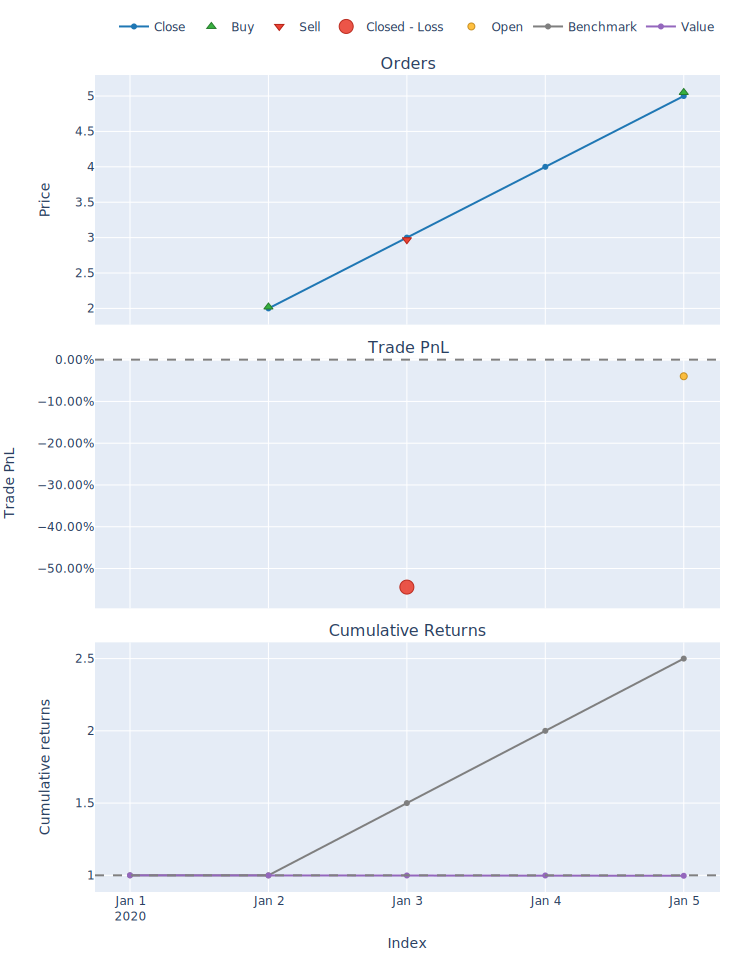

In [132]:
portfolio['a'].plot().show_svg()

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'orders' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'trade_pnl' does not support grouped data



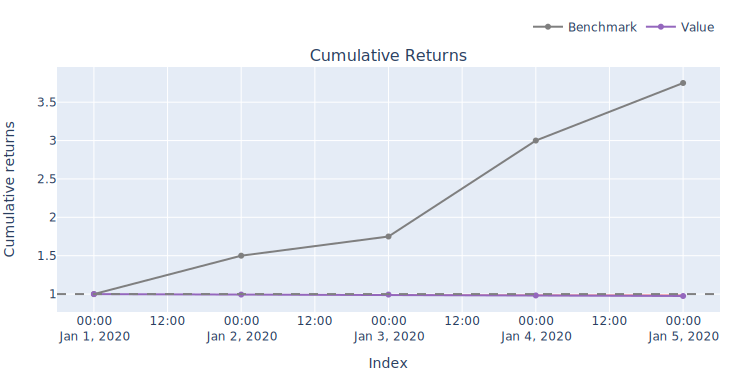

In [133]:
portfolio_shared['first'].plot().show_svg()

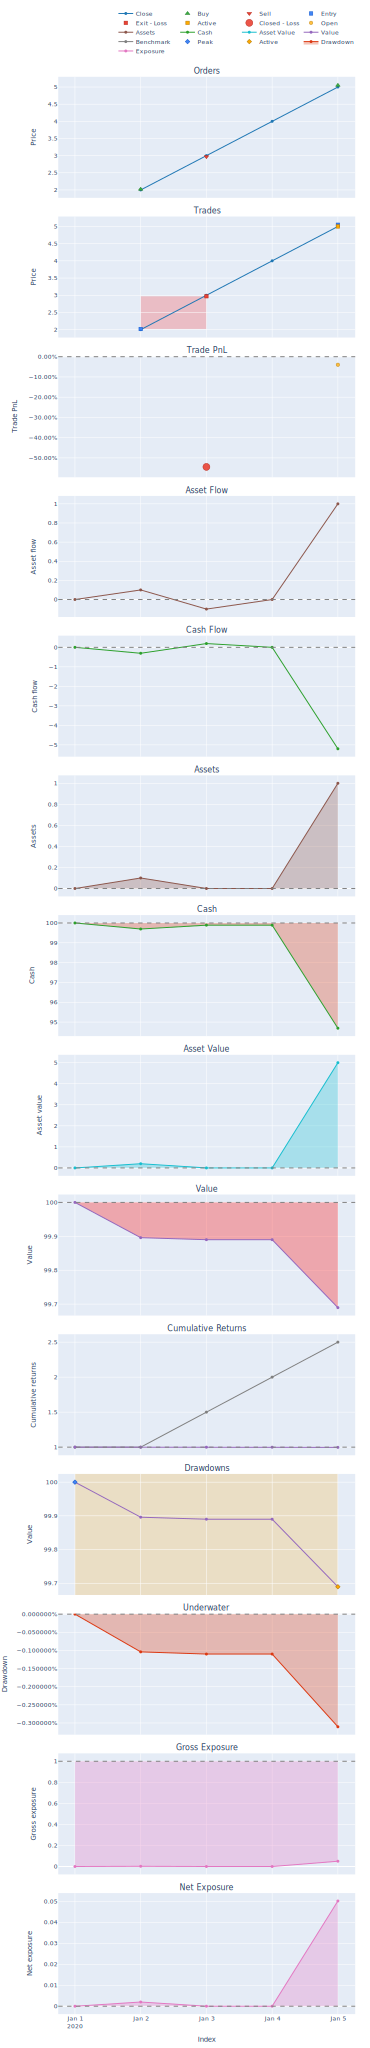

In [134]:
portfolio['a'].plot(subplots='all').show_svg()

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'orders' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'trades' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'trade_pnl' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'asset_flow' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'assets' does not support grouped data



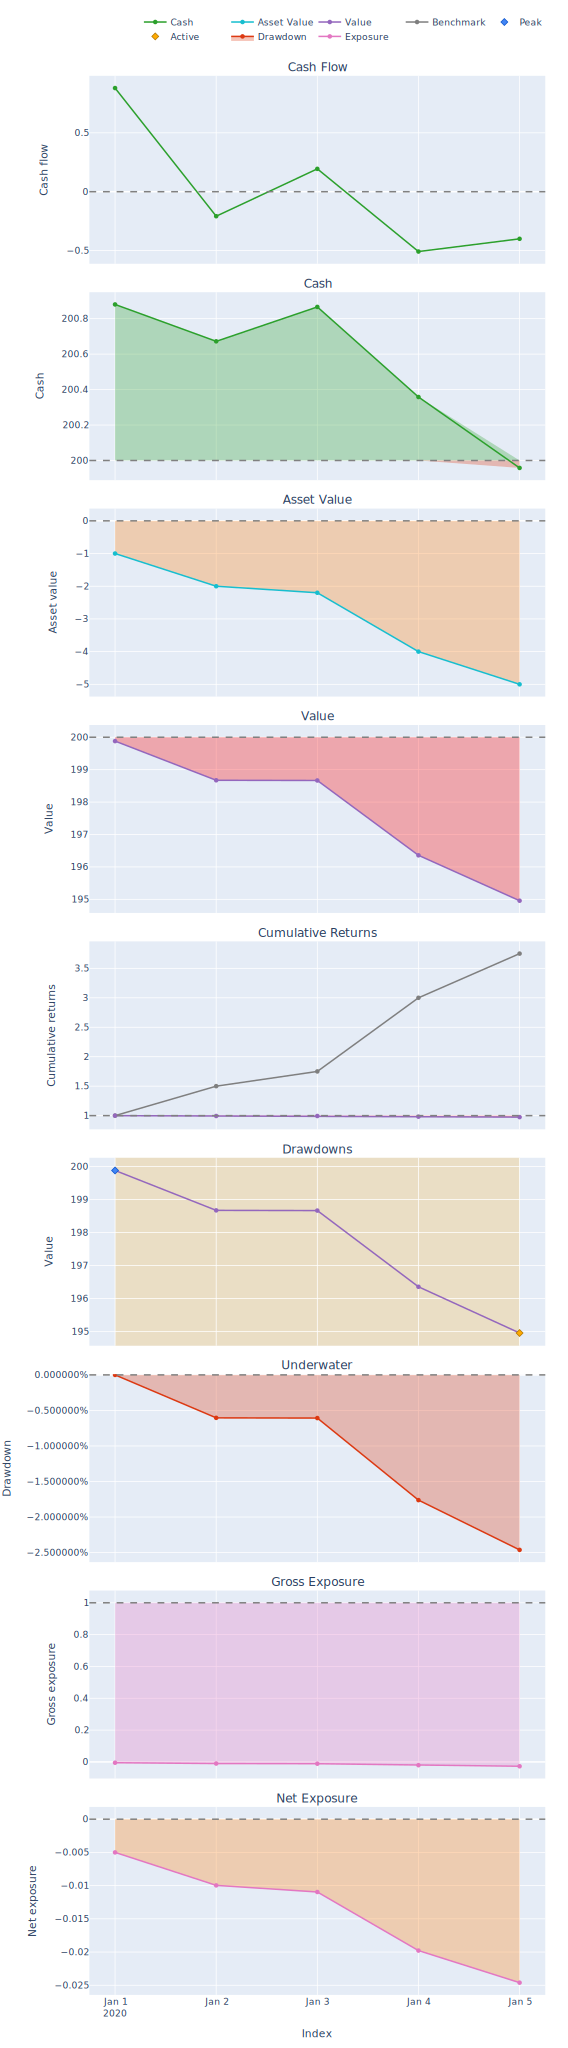

In [135]:
portfolio_shared['first'].plot(subplots='all').show_svg()

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'orders' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'trades' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'trade_pnl' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'asset_flow' does not support grouped data

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/plots_builder.py:355: UserWarning:

Subplot 'assets' does not support grouped data



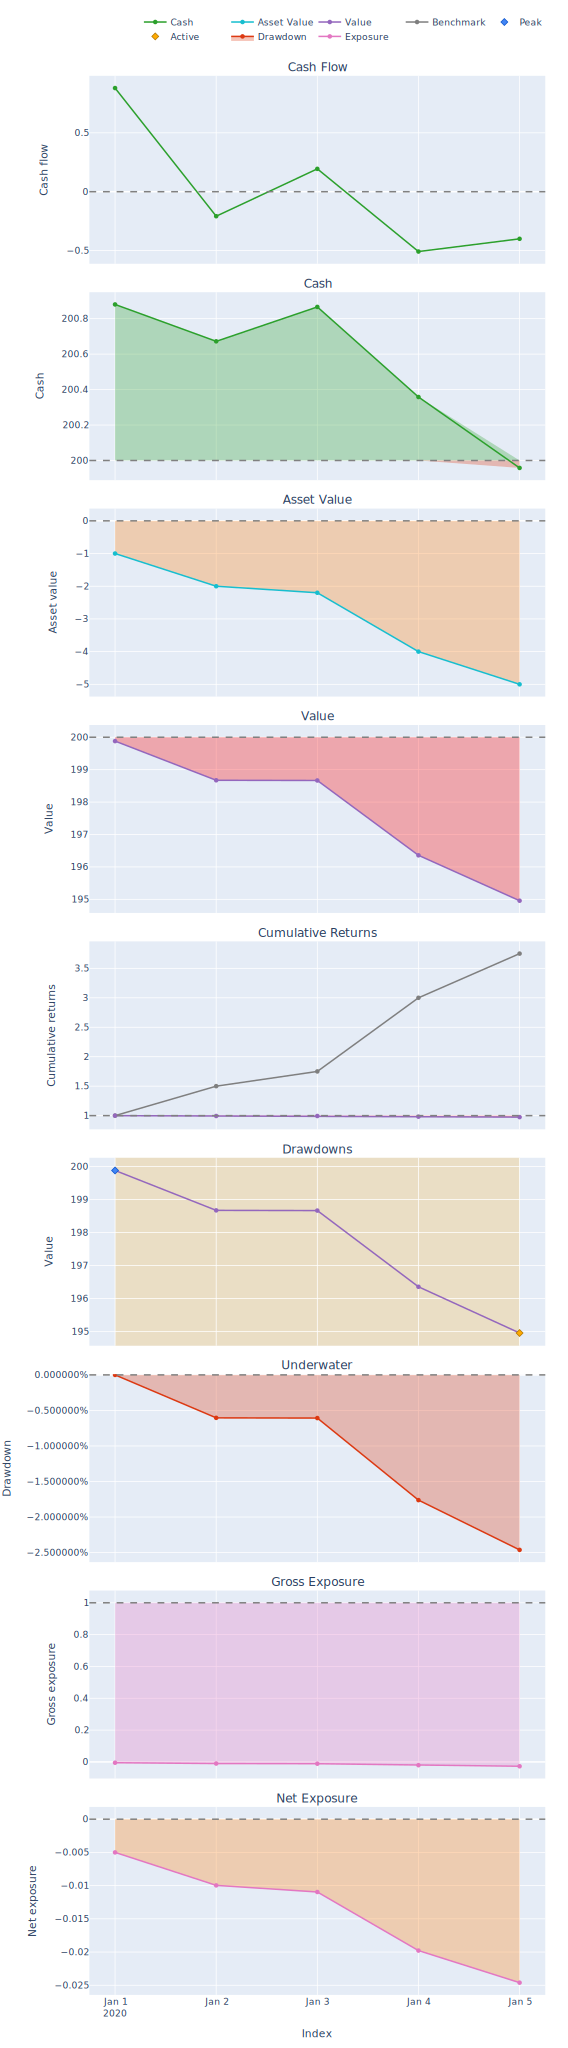

In [136]:
portfolio_shared.plot(subplots='all', column='first').show_svg()

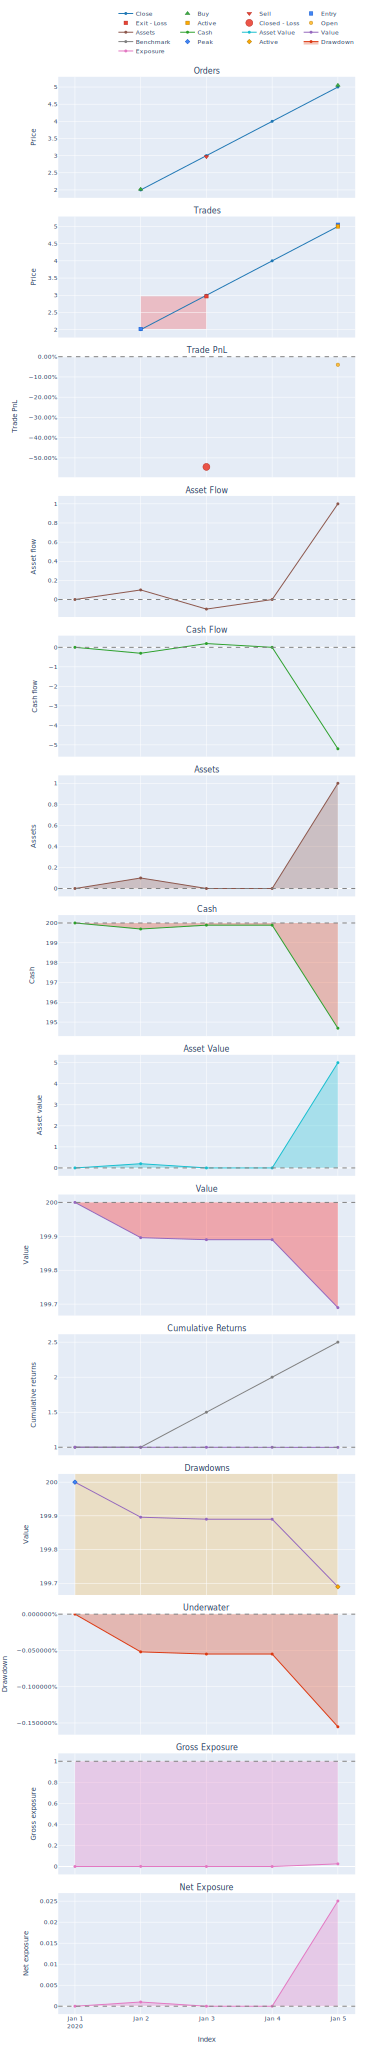

In [137]:
portfolio_shared.plot(subplots='all', column='a', group_by=False).show_svg()

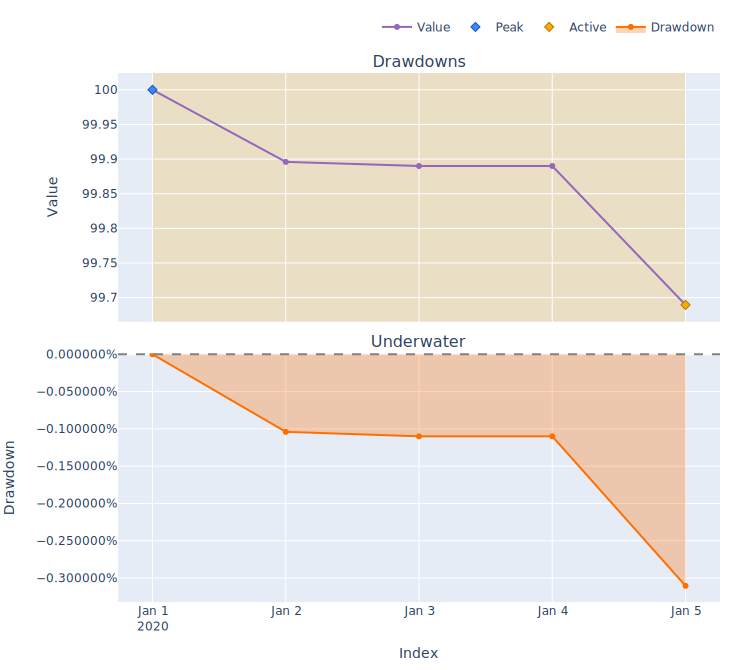

In [138]:
from vectorbt.utils.colors import adjust_opacity

portfolio['a'].plot(
    subplots=['drawdowns', 'underwater'],
    subplot_settings=dict(
        drawdowns=dict(top_n=3),
        underwater=dict(
            trace_kwargs=dict(
                line_color='#FF6F00',
                fillcolor=adjust_opacity('#FF6F00', 0.3)
            )
        )
    )
).show_svg()

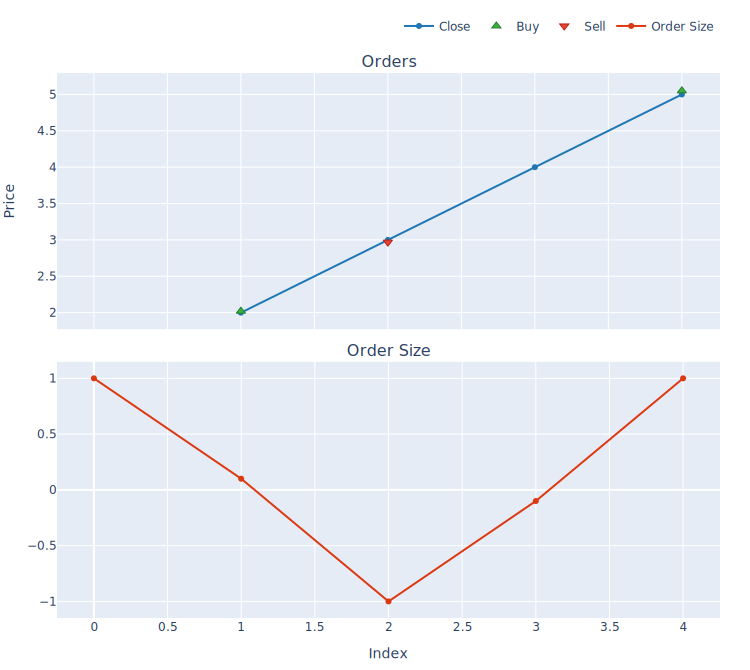

In [139]:
from vectorbt import settings
color_schema = settings['plotting']['color_schema']

fig = portfolio['a'].plot(subplots=[
    'orders',
    ('order_size', dict(title='Order Size', check_is_not_grouped=True))  # placeholder
])

order_size.vbt.plot(trace_kwargs=dict(name='Order Size'), add_trace_kwargs=dict(row=2, col=1), fig=fig).show_svg()